<a href="https://colab.research.google.com/github/enok/flowpredict/blob/main/flowpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free Cash Flow Forecasting

The objective of the thesis is to forecast the Free Cash Flow for one year (2024).
Free Cash Flow is one of the pillars for valuing a company. This aids in the decision-making process for buying/selling shares of companies listed on the stock exchange.

I am using data from 2011 to 2022 for training and 2023 for testing, and forecasting from the second half of 2023 to 2024.

<small><div style="text-align: right">The data will consist of quarterly reports spanning from 2011 to 2022 (12 years).</div></small>

### Mounting Google Drive (if is not running locally)

In [1]:
def is_running_in_colab():
    try:
        from google.colab import drive
        drive.mount('/content/gdrive', force_remount=True)
        %cd '/content/gdrive/MyDrive/cursos/usp/mba/data-science/tcc/code/flowpredict'
        %ls
        return True
    except ImportError:
        return False

if is_running_in_colab():
    print("Running inside Google Colab!")
else:
    print("Not running inside Google Colab.")

Not running inside Google Colab.


### Installing libs

In [2]:
%pip install arch
%pip install beautifulsoup4
%pip install chardet
%pip install files
%pip install matplotlib
%pip install pmdarima
%pip install pymannkendall
%pip install requests
%pip install seaborn
%pip install statsmodels
%pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

### Global settings, variables and functions

In [3]:
import os
import pandas as pd
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', 15)
pd.reset_option('display.max_columns')
pd.set_option('display.width', 400)
#pd.reset_option('display.width')

base_url = "https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/"

P_VALUE = 0.05
DIRECTORY = '.'
SEPARATOR = ';'
INTERPOLATION_TYPE = 'linear'

processed_folder = 'processed_files'
os.makedirs(processed_folder, exist_ok=True)
formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

companies = {
    20257: {"name": "Taesa", "ticker": "TAEE11"}
}

accounts_to_calculate_fcfe = {
	'VL_CONTA_1.01': {"code": "1.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_1.01.01': {"code": "1.01.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_1.01.03': {"code": "1.01.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_1.02.01': {"code": "1.02.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_1.02.03': {"code": "1.02.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_1.02.04': {"code": "1.02.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.01': {"code": "2.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.01.02': {"code": "2.01.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.01.03': {"code": "2.01.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.01.04': {"code": "2.01.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.01.05': {"code": "2.01.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.02.01': {"code": "2.02.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.02.02': {"code": "2.02.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.02.03': {"code": "2.02.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.02.04': {"code": "2.02.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.03.01': {"code": "2.03.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.03.02': {"code": "2.03.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.03.04': {"code": "2.03.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.01': {"code": "3.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.02': {"code": "3.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.03': {"code": "3.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.04': {"code": "3.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.05': {"code": "3.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.06': {"code": "3.06", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.07': {"code": "3.07", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.08': {"code": "3.08", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.09': {"code": "3.09", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.11': {"code": "3.11", "stationary": False, "diff_count": 0},
	'VL_CONTA_6.01': {"code": "6.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_6.02': {"code": "6.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_6.03': {"code": "6.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_6.05': {"code": "6.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.01': {"code": "7.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.02': {"code": "7.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.03': {"code": "7.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.04.01': {"code": "7.04.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.05': {"code": "7.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.06': {"code": "7.06", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.07': {"code": "7.07", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.08': {"code": "7.08", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.01': {"code": "1.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.01.01': {"code": "1.01.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.01.03': {"code": "1.01.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.02.01': {"code": "1.02.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.02.03': {"code": "1.02.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.02.04': {"code": "1.02.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.01': {"code": "2.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.01.02': {"code": "2.01.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.01.03': {"code": "2.01.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.01.04': {"code": "2.01.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.01.05': {"code": "2.01.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.02.01': {"code": "2.02.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.02.02': {"code": "2.02.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.02.03': {"code": "2.02.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.02.04': {"code": "2.02.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.03.01': {"code": "2.03.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.03.02': {"code": "2.03.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.03.04': {"code": "2.03.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.01': {"code": "3.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.02': {"code": "3.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.03': {"code": "3.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.04': {"code": "3.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.05': {"code": "3.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.06': {"code": "3.06", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.07': {"code": "3.07", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.08': {"code": "3.08", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.09': {"code": "3.09", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.11': {"code": "3.11", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_6.01': {"code": "6.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_6.02': {"code": "6.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_6.03': {"code": "6.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_6.05': {"code": "6.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.01': {"code": "7.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.02': {"code": "7.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.03': {"code": "7.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.04.01': {"code": "7.04.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.05': {"code": "7.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.06': {"code": "7.06", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.07': {"code": "7.07", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.08': {"code": "7.08", "stationary": False, "diff_count": 0}
}

columns_to_forecast = [
	'VL_CONTA_1.01',
	'VL_CONTA_1.01.01',
	'VL_CONTA_1.02.03',
	'VL_CONTA_2.01',
	'VL_CONTA_2.01.04',
	'VL_CONTA_2.02.01',
	'VL_CONTA_PENULTIMO_1.01',
	'VL_CONTA_PENULTIMO_1.01.01',
	'VL_CONTA_PENULTIMO_1.02.03',
	'VL_CONTA_PENULTIMO_2.01',
	'VL_CONTA_PENULTIMO_2.01.04',
	'VL_CONTA_PENULTIMO_2.02.01',
	'VL_CONTA_3.11',
	'VL_CONTA_7.04.01'
]

def read_csv(df_name, directory=DIRECTORY, sep=SEPARATOR, index_col=None, frequency=None, interpolate=False, interpolation_type=INTERPOLATION_TYPE):
    """Reads a CSV file and optionally interpolates missing values."""
    file_name = f'df_{df_name}.csv'
    full_path = os.path.join(directory, file_name)

    if not os.path.exists(directory):
        raise FileNotFoundError(f'Directory {directory} does not exist.')

    df_read = pd.read_csv(full_path, sep=sep, parse_dates=True, index_col=index_col)

    if frequency:
        df_read = df_read.asfreq(frequency)

    if interpolate:
        df_read = df_read.interpolate(method=interpolation_type)

    return df_read

def saveToFile(dfName, df, directory='.', setIndex=True, verbose=True):
    fileName = 'df_' + dfName + '.csv'
    if (setIndex):
        df = df.set_index('DT_REFER')
    if verbose:
        print('\n-----------------------------------------------------------------')
        print(f'saving file: {fileName}\n')
        print('\ndf.info():\n')
        print(df.info())
        print('\ndf:\n')
        print(df)
        df.to_csv(directory + '/' + fileName, sep=';')
        print(df.head())


## 1 Downloading and loading stock market data from the CVM website.

### 1.1 Companies to be analised


| Company       | Ticker    | CVM Code  |
| :---          | :----     | ----:     |
| Taesa         | TAEE11    | 20257     |

### 1.2 Accounts selected

Based on:<br>
Investiment Valuation Tools and Techniques for Determining the Value of Any Asset (Aswath Damodaran)<br>
    CHAPTER 14 - Free Cash Flow to Equity Discount Models<br><br>

*Free Cash Flows to Equity (FCFE) = <br>
	Net income - (Capital expenditures - Depreciation) <br>
	- (Change in noncash working capital) <br>
	+ (New debt issued - Debt repayments)*<br><br>


*Fluxo de Caixa Livre para os Acionistas (FCLPA) = <br>
Lucro Líquido<br>
 \- (Investimentos em Ativos Fixos - Depreciação)<br>
 \- (Variação no Capital de Giro, excluindo Caixa)<br>
 \+ (Novas Dívidas Emitidas - Pagamentos de Dívida)*<br><br>

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>



**BPA**

| Code       | Description                                           |
| :---       | :----                                                 |
| 1.01       | Ativo Circulante                                      |
| 1.01.01    | Caixa e Equivalentes de Caixa                         |
| 1.02.03    | Imobilizado                                           |

<br>                                                                

**BPP**

| Code       | Description                                           |
| :---       | :----                                                 |
| 2.01       | Passivo Circulante                                    |
| 2.01.04    | Empréstimos e Financiamentos (Passivo Circulante)     |
| 2.02.01    | Empréstimos e Financiamentos (Passivo Nao Circulante) |

<br>                                                                
                                                                    
**DRE**

| Code       | Description                                           |
| :---       | :----                                                 |
| 3.11       | Lucro/Prejuízo Consolidado do Período                 |

<br>                                                                

**DVA**
                                                     
| Code       | Description                                           |
| :---       | :----                                                 |
| 7.04.01    | Depreciação, Amortização e Exaustão                   |


<small><div style="text-align: right">Source: <a>https://www.rad.cvm.gov.br/ENET/documentos/EspecificacaoArquivoXML_InformacoesTrimestrais.xlsx<a></div></small>

### 1.3 File Types

In [4]:
file_types = ['BPA', 'BPP', 'DRE', 'DRA', 'DMPL', 'DFC', 'DVA']
print(f'file_types selected: {file_types}')


file_types selected: ['BPA', 'BPP', 'DRE', 'DRA', 'DMPL', 'DFC', 'DVA']


### 1.4 Interval of years

In [5]:
year_interval_begin = 2011
year_interval_end = 2023
years = range(year_interval_begin, year_interval_end+1)


### 1.5 Download directory

In [6]:
download_dir = "downloaded_files"


### 1.6 Downloading balance sheets files

In [7]:
import os
import chardet
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import zipfile

def is_utf8(file_path):
    """Check if the file encoding is UTF-8."""
    try:
        with open(file_path, 'rb') as file:
            raw_data = file.read()
            result = chardet.detect(raw_data)
            return result['encoding'] == 'utf-8'
    except Exception:
        return False

def download_zips(base_url, download_dir, years_to_download):
    """Download ZIP files for the specified years."""
    response = requests.get(base_url)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, "html.parser")
    links = soup.find_all("a")

    for link in links:
        file_url = urljoin(base_url, link["href"])
        if file_url.endswith(".zip"):
            zip_file_name = os.path.basename(file_url)
            year_part = zip_file_name.split("_")[-1].split(".")[0]
            if year_part in years_to_download:
                if not os.path.exists(os.path.join(download_dir, zip_file_name)):
                    print(f"Downloading: {zip_file_name}")
                    with open(os.path.join(download_dir, zip_file_name), "wb") as file:
                        file_response = requests.get(file_url)
                        file.write(file_response.content)
                else:
                    print(f"File already exists: {zip_file_name}")

def unzip_files(download_dir):
    """Unzip downloaded ZIP files."""
    for zip_file_name in os.listdir(download_dir):
        if zip_file_name.endswith(".zip"):
            zip_file_path = os.path.join(download_dir, zip_file_name)
            zip_subdir = os.path.splitext(zip_file_name)[0]
            zip_subdir_path = os.path.join(download_dir, zip_subdir)

            if not os.path.exists(zip_subdir_path):
                print(f"Unzipping: {zip_file_name} -> {zip_subdir_path}")
                with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
                    zip_ref.extractall(zip_subdir_path)

def process_files(download_dir, file_types):
    """Process unzipped files."""
    for zip_subdir in os.listdir(download_dir):
        zip_subdir_path = os.path.join(download_dir, zip_subdir)
        marker_file_path = os.path.join(zip_subdir_path, "processed.txt")

        if os.path.isdir(zip_subdir_path) and not os.path.exists(marker_file_path):
            for root, _, files in os.walk(zip_subdir_path):
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    csv_file_type = os.path.splitext(file_name)[0][15:19].replace("_", "")
                    print(f"File type: {csv_file_type}")
                    if (csv_file_type not in file_types) or \
                        ("ind" in file_name) or \
                        ("DFC_MD" in file_name) or \
                        ("itr_cia_aberta_20" in file_name):

                        os.remove(file_path)
                        print(f"Removing file: {file_path}")
                    elif file_name.endswith(".csv") and not is_utf8(file_path):
                        print(f"Converting encoding: {file_path}")
                        with open(file_path, 'r', encoding='ISO-8859-1') as source_file:
                            content = source_file.read()
                        with open(file_path, 'w', encoding='utf-8') as target_file:
                            target_file.write(content)

            # Create the marker file after processing all files in the directory
            with open(marker_file_path, 'w') as marker_file:
                marker_file.write("Files in this directory have been processed.")

os.makedirs(download_dir, exist_ok=True)
years_to_download = set(str(year) for year in years)

download_zips(base_url, download_dir, years_to_download)
unzip_files(download_dir)
process_files(download_dir, file_types)

print("Download, extraction, file removal, and encoding conversion completed.")


File already exists: itr_cia_aberta_2011.zip
File already exists: itr_cia_aberta_2012.zip
File already exists: itr_cia_aberta_2013.zip
File already exists: itr_cia_aberta_2014.zip
File already exists: itr_cia_aberta_2015.zip
File already exists: itr_cia_aberta_2016.zip
File already exists: itr_cia_aberta_2017.zip
File already exists: itr_cia_aberta_2018.zip
File already exists: itr_cia_aberta_2019.zip
File already exists: itr_cia_aberta_2020.zip
File already exists: itr_cia_aberta_2021.zip
File already exists: itr_cia_aberta_2022.zip
File already exists: itr_cia_aberta_2023.zip
Download, extraction, file removal, and encoding conversion completed.


### 1.7 Creating the dataframes

In [8]:
import os
import pandas as pd

dataframes = {
    'BPA': None,
    'BPP': None,
    'DRE': None,
    'DRA': None,
    'DMPL': None,
    'DFC': None,
    'DVA': None
}

# Load files into Data Frames
for dir_name in os.listdir(download_dir):
    if not dir_name.endswith(".zip"):
        dir_path = os.path.join(download_dir, dir_name)

        for csv_file_name in os.listdir(dir_path):
            if csv_file_name.endswith(".csv"):
                csv_file_path = os.path.join(dir_path, csv_file_name)
                print("\n-------------------------------------------------------")
                print(f"Reading csv file: {csv_file_path}")

                csv_file_type = os.path.splitext(csv_file_name)[0][15:19].replace("_", "")
                print(f"CSV type: {csv_file_type}")

                local_df = pd.read_csv(csv_file_path, sep=';')

                local_df['DT_REFER'] = pd.to_datetime(local_df['DT_REFER'], format='%Y-%m-%d')
                local_df['DT_FIM_EXERC'] = pd.to_datetime(local_df['DT_FIM_EXERC'], format='%Y-%m-%d')

                print(f"Dataframe size: {len(local_df)}")

                # Checking if the file type is in dataframes dictionary
                if csv_file_type in dataframes:
                    if dataframes[csv_file_type] is None:
                        dataframes[csv_file_type] = local_df
                    else:
                        dataframes[csv_file_type] = pd.concat([dataframes[csv_file_type], local_df])
                    print(f"Dataframe size - after concat: {len(dataframes[csv_file_type])}")

for key, df_original in dataframes.items():
    print(f"\n{key}:")
    print(df_original.head())



-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_BPA_con_2011.csv
CSV type: BPA
Dataframe size: 135870
Dataframe size - after concat: 135870

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_BPP_con_2011.csv
CSV type: BPP
Dataframe size: 231544
Dataframe size - after concat: 231544

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_DFC_MI_con_2011.csv
CSV type: DFC
Dataframe size: 81094
Dataframe size - after concat: 81094

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_DMPL_con_2011.csv
CSV type: DMPL
Dataframe size: 470968
Dataframe size - after concat: 470968

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_a

### 1.8 Saving Dataframes

#### 1.8.1 Creating column DT_INI_EXERC

In [9]:
import pandas as pd

def createDT_INI_EXERC(df_name, df):
    """Creating column DT_INI_EXERC"""
    print(f'Creating column DT_INI_EXERC for: {df_name} accounts')

    target_values = [
        'DF Consolidado - Balanço Patrimonial Ativo',
        'DF Consolidado - Balanço Patrimonial Passivo'
    ]
    df['DT_FIM_EXERC'] = pd.to_datetime(df['DT_FIM_EXERC'])

    df.loc[df['GRUPO_DFP'].isin(target_values), 'DT_INI_EXERC'] = df['DT_FIM_EXERC'] - pd.DateOffset(months=3)

    cols = list(df.columns)
    cols.remove('DT_INI_EXERC')
    cols.insert(9, 'DT_INI_EXERC')
    df = df[cols]
    
    return df

# Creating column DT_INI_EXERC for BPA and BPP accounts
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = createDT_INI_EXERC(key, df_original)
        dataframes[key] = df_original




Creating column DT_INI_EXERC for: BPA accounts


/tmp/ipykernel_736951/1679919594.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[df['GRUPO_DFP'].isin(target_values), 'DT_INI_EXERC'] = df['DT_FIM_EXERC'] - pd.DateOffset(months=3)


Creating column DT_INI_EXERC for: BPP accounts


/tmp/ipykernel_736951/1679919594.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[df['GRUPO_DFP'].isin(target_values), 'DT_INI_EXERC'] = df['DT_FIM_EXERC'] - pd.DateOffset(months=3)


Creating column DT_INI_EXERC for: DRE accounts
Creating column DT_INI_EXERC for: DRA accounts
Creating column DT_INI_EXERC for: DMPL accounts
Creating column DT_INI_EXERC for: DFC accounts
Creating column DT_INI_EXERC for: DVA accounts


#### 1.8.2 Saving

In [10]:
for key, df_original in dataframes.items():
    if df_original is not None:
        saveToFile(key, df_original, processed_folder, verbose=False)


## 2 Data analising

### 2.1 Loading Dataframes

In [11]:
# Using dictionary comprehension to load dataframes
dataframes = {df_name: read_csv(df_name, processed_folder) for df_name in dataframes.keys()}


## 3 Data cleansing

### 3.1 Cleaning up

In [12]:
import numpy as np

accounts_to_be_kept = ['1.01','1.01.01','1.01.03','1.02.01','1.02.03','1.02.04',
                    '2.01','2.01.02','2.01.03','2.01.04','2.01.05','2.02.01','2.02.02','2.02.03','2.02.04','2.03.01','2.03.02','2.03.04',
                    '3.01','3.02','3.03','3.04','3.05','3.06','3.07','3.08','3.09','3.11',
                    '6.01','6.02','6.03','6.05',
                    '7.01','7.02','7.03','7.04.01','7.05','7.06','7.07','7.08']
print(f'accounts selected: {accounts_to_be_kept}')

# calculate value according to field ESCALA_MOELA
def set_vl_conta(df_name, df):
    print(f'setting vl_conta based on escala_moeda: {df_name}')
    df['VL_CONTA'] = np.where(df['ESCALA_MOEDA'] == 'MIL', df['VL_CONTA'] * 1000, df['VL_CONTA'])
    return df

def remove_non_mandatory_columns(df_name, df):
    print(f'removing non mandatory columns from: {df_name}')
    existing_cols = df.columns.intersection(['CNPJ_CIA', 'VERSAO', 'DENOM_CIA', 'MOEDA', 'ESCALA_MOEDA', 'DT_INI_EXERC', 'DT_FIM_EXERC', 'COLUNA_DF', 'ST_CONTA_FIXA'])
    return df.drop(columns=existing_cols, axis=1)

def remove_non_used_accounts(df_name, df):
    print(f'removing non used accounts for: {df_name}')
    print(f'accounts selected: {accounts_to_be_kept}')
    return df[df['CD_CONTA'].isin(accounts_to_be_kept)]

# Calculating values according to field ESCALA_MOELA for all DFs
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = set_vl_conta(key, df_original)
        dataframes[key] = df_original

# Removing non-mandatory columns
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = remove_non_mandatory_columns(key, df_original)
        dataframes[key] = df_original

# Removing non-used accounts
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = remove_non_used_accounts(key, df_original)
        dataframes[key] = df_original

print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        print("\n")
        print(df_original.head())


accounts selected: ['1.01', '1.01.01', '1.01.03', '1.02.01', '1.02.03', '1.02.04', '2.01', '2.01.02', '2.01.03', '2.01.04', '2.01.05', '2.02.01', '2.02.02', '2.02.03', '2.02.04', '2.03.01', '2.03.02', '2.03.04', '3.01', '3.02', '3.03', '3.04', '3.05', '3.06', '3.07', '3.08', '3.09', '3.11', '6.01', '6.02', '6.03', '6.05', '7.01', '7.02', '7.03', '7.04.01', '7.05', '7.06', '7.07', '7.08']


setting vl_conta based on escala_moeda: BPA
setting vl_conta based on escala_moeda: BPP
setting vl_conta based on escala_moeda: DRE
setting vl_conta based on escala_moeda: DRA
setting vl_conta based on escala_moeda: DMPL
setting vl_conta based on escala_moeda: DFC
setting vl_conta based on escala_moeda: DVA


removing non mandatory columns from: BPA
removing non mandatory columns from: BPP
removing non mandatory columns from: DRE
removing non mandatory columns from: DRA
removing non mandatory columns from: DMPL
removing non mandatory columns from: DFC
removing non mandatory columns from: DVA


removi

## 4 Data transformation

### 4.1 Merge dataframes into one

In [13]:
df_original = pd.concat(dataframes.values())

print(df_original.dtypes)
print("\n")
df_original.head()


DT_REFER        object
CD_CVM           int64
GRUPO_DFP       object
ORDEM_EXERC     object
CD_CONTA        object
DS_CONTA        object
VL_CONTA       float64
dtype: object




,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
2,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01,Ativo Circulante,3.280595e+10
3,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01,Ativo Circulante,3.473632e+10
4,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.127839e+10
5,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.235836e+10
22,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.03,Contas a Receber,4.016006e+09


### 4.2 Saving merged Dataframes

In [14]:
saveToFile('MERGED', df_original, processed_folder, verbose=False)


### 4.3 Loading merged Dataframes

In [15]:
df_original = read_csv('MERGED', processed_folder)

print("\n")
df_original.head()

/tmp/ipykernel_736951/2575665460.py:133: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(full_path, sep=sep, parse_dates=True, index_col=index_col)


,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
0,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01,Ativo Circulante,3.280595e+10
1,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01,Ativo Circulante,3.473632e+10
2,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.127839e+10
3,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.235836e+10
4,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.03,Contas a Receber,4.016006e+09


### 4.4 Selecting companies

In [16]:
print(f'selecting companies : {companies}')
df_companies = df_original[df_original['CD_CVM'].isin(companies)]

print("\n")
df_companies.head()

selecting companies : {20257: {'name': 'Taesa', 'ticker': 'TAEE11'}}




,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
4060,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01,Ativo Circulante,1.081396e+09
4061,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01,Ativo Circulante,1.304282e+09
4062,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,4.145780e+08
4063,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,6.404360e+08
4064,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.03,Contas a Receber,6.347730e+08


### 4.5 Reordering columns

In [17]:
df_companies = df_companies[['DT_REFER', 'CD_CONTA', 'CD_CVM', 'GRUPO_DFP', 'ORDEM_EXERC', 'DS_CONTA', 'VL_CONTA']]


### 4.6 Saving companies Dataframe

In [18]:
saveToFile('companies', df_companies, verbose=False)


### 4.7 Preparing for transposing

#### 4.7.0 Loading dataframe

In [19]:
df_original = read_csv('companies')

print("\n")
df_original.head()


,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,6.347730e+08


#### 4.7.1 Create column 'VL_CONTA_PENULTIMO'

In [20]:
df_original.head()


,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,6.347730e+08


In [21]:
df_original[df_original['CD_CONTA'] == '3.11'].head()


,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA
1386,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,69264000.0
1387,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,72834000.0
1424,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,141536000.0
1425,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,72272000.0
1426,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,145580000.0


In [22]:
def createPenultimo_VL_CONTA(df, position):

    columnName = 'VL_CONTA'
    newColumnName = columnName + '_PENULTIMO'

    df[newColumnName] = np.where(
        (df['ORDEM_EXERC'] == 'PENÚLTIMO'),
        df[columnName],
        None)

    # remove this same values from column
    df[columnName] = np.where(
        df['ORDEM_EXERC'] != 'PENÚLTIMO',
        df[columnName],
        None)

    df[newColumnName] = df[newColumnName].astype(float)
    df[columnName] = df[columnName].astype(float)

    # Reorder the columns to move to correct position
    cols = list(df.columns)

    cols.remove(newColumnName)
    cols.insert(position, newColumnName)
    df = df[cols]

    return df

df_original = createPenultimo_VL_CONTA(df_original, 8)

print(df_original.dtypes)
print("\n")
df_original.head()

DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
GRUPO_DFP              object
ORDEM_EXERC            object
DS_CONTA               object
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object




,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,NaN,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09,NaN
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,NaN,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08,NaN
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,NaN,6.347730e+08


In [23]:
df_original[df_original['CD_CONTA'] == '3.11'].head()


,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA,VL_CONTA_PENULTIMO
1386,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,NaN,69264000.0
1387,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,72834000.0,NaN
1424,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,NaN,141536000.0
1425,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,NaN,72272000.0
1426,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,145580000.0,NaN


#### 4.7.2 Remove disposable columns

In [24]:
print("\n")
df_original.head()


,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,NaN,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09,NaN
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,NaN,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08,NaN
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,NaN,6.347730e+08


In [25]:
cols = df_original.columns.intersection(['GRUPO_DFP', 'DS_CONTA', 'ORDEM_EXERC'])
df_original = df_original.drop(columns=cols, axis=1)
    
print("\n")
df_original.head()


,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,NaN,1.081396e+09
1,2011-03-31,1.01,20257,1.304282e+09,NaN
2,2011-03-31,1.01.01,20257,NaN,4.145780e+08
3,2011-03-31,1.01.01,20257,6.404360e+08,NaN
4,2011-03-31,1.01.03,20257,NaN,6.347730e+08


In [26]:
df_original[df_original['CD_CONTA'] == '3.11'].head()


,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
1386,2011-03-31,3.11,20257,NaN,69264000.0
1387,2011-03-31,3.11,20257,72834000.0,NaN
1424,2011-06-30,3.11,20257,NaN,141536000.0
1425,2011-06-30,3.11,20257,NaN,72272000.0
1426,2011-06-30,3.11,20257,145580000.0,NaN


#### 4.7.3 Group by 'DT_REFER', 'CD_CVM', and 'CD_CONTA' and aggregate the values

In [27]:
agg_funcs = {
    'VL_CONTA_PENULTIMO': 'last',
    'VL_CONTA': 'last'
}

df_original = df_original.groupby(['DT_REFER', 'CD_CVM', 'CD_CONTA']).agg(agg_funcs).reset_index()

# Reorder the columns as needed
df_original = df_original[['DT_REFER', 'CD_CONTA', 'CD_CVM', 'VL_CONTA', 'VL_CONTA_PENULTIMO']]

# View the final DataFrame
print("\n")
print("---------------------------------------")
df_original[df_original['CD_CVM'] == 20257].head()




---------------------------------------


,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


#### 4.7.4 Saving df before transposing

In [28]:
saveToFile('companies_before_transposing', df_original, verbose=False)


#### 4.7.5 Loading df before transposing

In [29]:
companies_before_transposing = read_csv('companies_before_transposing')

print("\n")
companies_before_transposing.head()


,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


#### 4.7.6 Dealing with missing values

##### 4.7.6.1 Saving

In [30]:
def missingValues(df):
    df['VL_CONTA'].fillna(0, inplace=True)
    df['VL_CONTA_PENULTIMO'].fillna(0, inplace=True)

    df.fillna('', inplace=True)

missingValues(companies_before_transposing)

saveToFile('companies_before_transposing_without_missing_values', df_original, verbose=False)


##### 4.7.6.2 Loading

In [31]:
df_original = read_csv('companies_before_transposing_without_missing_values')

missingValues(df_original)

print("\n")
df_original.head()


,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


#### 4.7.7 Transforming rows into column to have one register by date, company and account type

In [32]:
df_original.head()


,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


In [33]:
# Creating the pivot table
df = df_original.pivot_table(
    index=['DT_REFER', 'CD_CVM'],
    columns='CD_CONTA',
    values=['VL_CONTA', 'VL_CONTA_PENULTIMO'],
    aggfunc='first'
).reset_index()

# Flattening the multi-level columns
df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]

# Reordering the columns
ordered_columns = (
    ['DT_REFER', 'CD_CVM'] +
    [col for col in df.columns if col.startswith('VL_CONTA_') and not col.startswith('VL_CONTA_PENULTIMO_')] +
    [col for col in df.columns if col.startswith('VL_CONTA_PENULTIMO_')]
)

df = df[ordered_columns]

print("\n-------------------------------------")
print(df)
print("-------------------------------------\n")

def custom_agg(series):
    # If the dtype is datetime, check for non-NaT values
    if series.dtype == 'datetime64[ns]':
        non_nat_values = [val for val in series if not pd.isna(val)]
        return non_nat_values[0] if non_nat_values else pd.NaT
    else:
        # If it's numeric, check for non-NaN values
        if pd.api.types.is_numeric_dtype(series):
            non_nan_values = [val for val in series if not pd.isna(val)]
            return non_nan_values[0] if non_nan_values else np.nan
        # Else check for non-empty strings
        else:
            non_empty_values = [val for val in series if val != '']
            return non_empty_values[0] if non_empty_values else ''

# Create an aggregation dictionary excluding columns you're grouping by
grouping_columns = ['DT_REFER', 'CD_CVM']
agg_dict = {col: custom_agg for col in ordered_columns if col not in grouping_columns}

# Group by 'DT_REFER', and 'CD_CVM', then aggregate
grouped_df = df.groupby(grouping_columns).agg(agg_dict).reset_index()

print("\n-------------------------------------")
print(df)
print("-------------------------------------\n")

saveToFile('pivot', df)



-------------------------------------
      DT_REFER  CD_CVM  VL_CONTA_1.01  VL_CONTA_1.01.01  VL_CONTA_1.01.03  VL_CONTA_1.02.01  VL_CONTA_1.02.03  VL_CONTA_1.02.04  VL_CONTA_2.01  VL_CONTA_2.01.02  ...  VL_CONTA_PENULTIMO_6.03  VL_CONTA_PENULTIMO_6.05  VL_CONTA_PENULTIMO_7.01  VL_CONTA_PENULTIMO_7.02  VL_CONTA_PENULTIMO_7.03  VL_CONTA_PENULTIMO_7.04.01  VL_CONTA_PENULTIMO_7.05  VL_CONTA_PENULTIMO_7.06  VL_CONTA_PENULTIMO_7.07  \
0   2011-03-31   20257   1.304282e+09      6.404360e+08      6.352210e+08      3.351158e+09        12438000.0         4090000.0   3.347010e+08         8245000.0  ...            -5.283400e+07             8.208800e+07             1.779060e+08              -14578000.0             1.633280e+08                  -3654000.0             1.596740e+08                8823000.0             1.684970e+08   
1   2011-06-30   20257   1.015506e+09      3.560120e+08      6.394430e+08      3.294360e+09        12622000.0         4022000.0   4.577490e+08         5017000.0  ...  

#### 4.7.8 Removing high correlations

In [34]:
import pandas as pd

df = read_csv('pivot', index_col="DT_REFER")

# Calculating correlation matrix
correlation_matrix = df.corr()

# Identifying high correlated columns pairs
highly_correlated_pairs = (correlation_matrix.abs() > 0.7) & (correlation_matrix.abs() < 1)
print(f'highly_correlated_pairs.columns: {highly_correlated_pairs.columns}')

# Removing high correlation, keeping junt one of the column pairs
for col in highly_correlated_pairs.columns:
    print(f'\ncol: {col}')
    correlated_columns = highly_correlated_pairs.index[highly_correlated_pairs[col]]
    print(f'correlated_columns: {correlated_columns}')
    for correlated_column in correlated_columns:
        if correlated_column != col:
            if df.columns.__contains__(correlated_column):
                if correlated_column not in columns_to_forecast:
                    df = df.drop(columns=correlated_column)
                    del accounts_to_calculate_fcfe[correlated_column]

print("\n")
df.info()

highly_correlated_pairs.columns: Index(['CD_CVM', 'VL_CONTA_1.01', 'VL_CONTA_1.01.01', 'VL_CONTA_1.01.03', 'VL_CONTA_1.02.01', 'VL_CONTA_1.02.03', 'VL_CONTA_1.02.04', 'VL_CONTA_2.01', 'VL_CONTA_2.01.02', 'VL_CONTA_2.01.03', 'VL_CONTA_2.01.04', 'VL_CONTA_2.01.05', 'VL_CONTA_2.02.01', 'VL_CONTA_2.02.02', 'VL_CONTA_2.02.03', 'VL_CONTA_2.02.04', 'VL_CONTA_2.03.01', 'VL_CONTA_2.03.02', 'VL_CONTA_2.03.04', 'VL_CONTA_3.01',
       'VL_CONTA_3.02', 'VL_CONTA_3.03', 'VL_CONTA_3.04', 'VL_CONTA_3.05', 'VL_CONTA_3.06', 'VL_CONTA_3.07', 'VL_CONTA_3.08', 'VL_CONTA_3.09', 'VL_CONTA_3.11', 'VL_CONTA_6.01', 'VL_CONTA_6.02', 'VL_CONTA_6.03', 'VL_CONTA_6.05', 'VL_CONTA_7.01', 'VL_CONTA_7.02', 'VL_CONTA_7.03', 'VL_CONTA_7.04.01', 'VL_CONTA_7.05', 'VL_CONTA_7.06', 'VL_CONTA_7.07', 'VL_CONTA_7.08', 'VL_CONTA_PENULTIMO_1.01',
       'VL_CONTA_PENULTIMO_1.01.01', 'VL_CONTA_PENULTIMO_1.01.03', 'VL_CONTA_PENULTIMO_1.02.01', 'VL_CONTA_PENULTIMO_1.02.03', 'VL_CONTA_PENULTIMO_1.02.04', 'VL_CONTA_PENULTIMO_2.01', '

#### 4.7.9 Saving results

In [35]:
saveToFile('pivot', df, setIndex=False, verbose=False)


## 5 Forecasting

### 5.1 Analysing


#### 5.1.1 Series stationarity analysis

**Observed, Seasonal, Tend and Residuals**

**Bibliografy:**

- Dickey, D.A. & Fuller, W.A. (1979). Distribution of the Estimators for Autoregressive Time Series With a Unit Root. Journal of the American Statistical Association, 74(366a), 427-431.

- Kwiatkowski, D., Phillips, P.C.B., Schmidt, P., & Shin, Y. (1992). Testing the null hypothesis of stationarity against the alternative of a unit root. Journal of Econometrics, 54(1-3), 159-178.

- Phillips, P.C.B. & Perron, P. (1988). Testing for a unit root in time series regression. Biometrika, 75(2), 335-346.


##### 5.1.1.1 Reading dataframe

In [36]:
import numpy as np

df = read_csv('pivot', index_col="DT_REFER")

print("\n---------------------------------------------")
print('df.isnull().sum()')
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])

print("\n---------------------------------------------")
print('np.isinf(df).sum()')
isinf_counts = np.isinf(df).sum()
print(isinf_counts[isinf_counts > 0])

print("\n---------------------------------------------")
print('df.head()')
print(df.head())



---------------------------------------------
df.isnull().sum()
Series([], dtype: int64)

---------------------------------------------
np.isinf(df).sum()
Series([], dtype: int64)

---------------------------------------------
df.head()
            CD_CVM  VL_CONTA_1.01  VL_CONTA_1.01.01  VL_CONTA_1.01.03  VL_CONTA_1.02.01  VL_CONTA_1.02.03  VL_CONTA_1.02.04  VL_CONTA_2.01  VL_CONTA_2.01.02  VL_CONTA_2.01.03  ...  VL_CONTA_PENULTIMO_6.03  VL_CONTA_PENULTIMO_6.05  VL_CONTA_PENULTIMO_7.01  VL_CONTA_PENULTIMO_7.02  VL_CONTA_PENULTIMO_7.03  VL_CONTA_PENULTIMO_7.04.01  VL_CONTA_PENULTIMO_7.05  VL_CONTA_PENULTIMO_7.06  \
DT_REFER                                                                                                                                                                        ...                                                                                                                                                                                                     

##### 5.1.1.2 Identifying if series is stationary

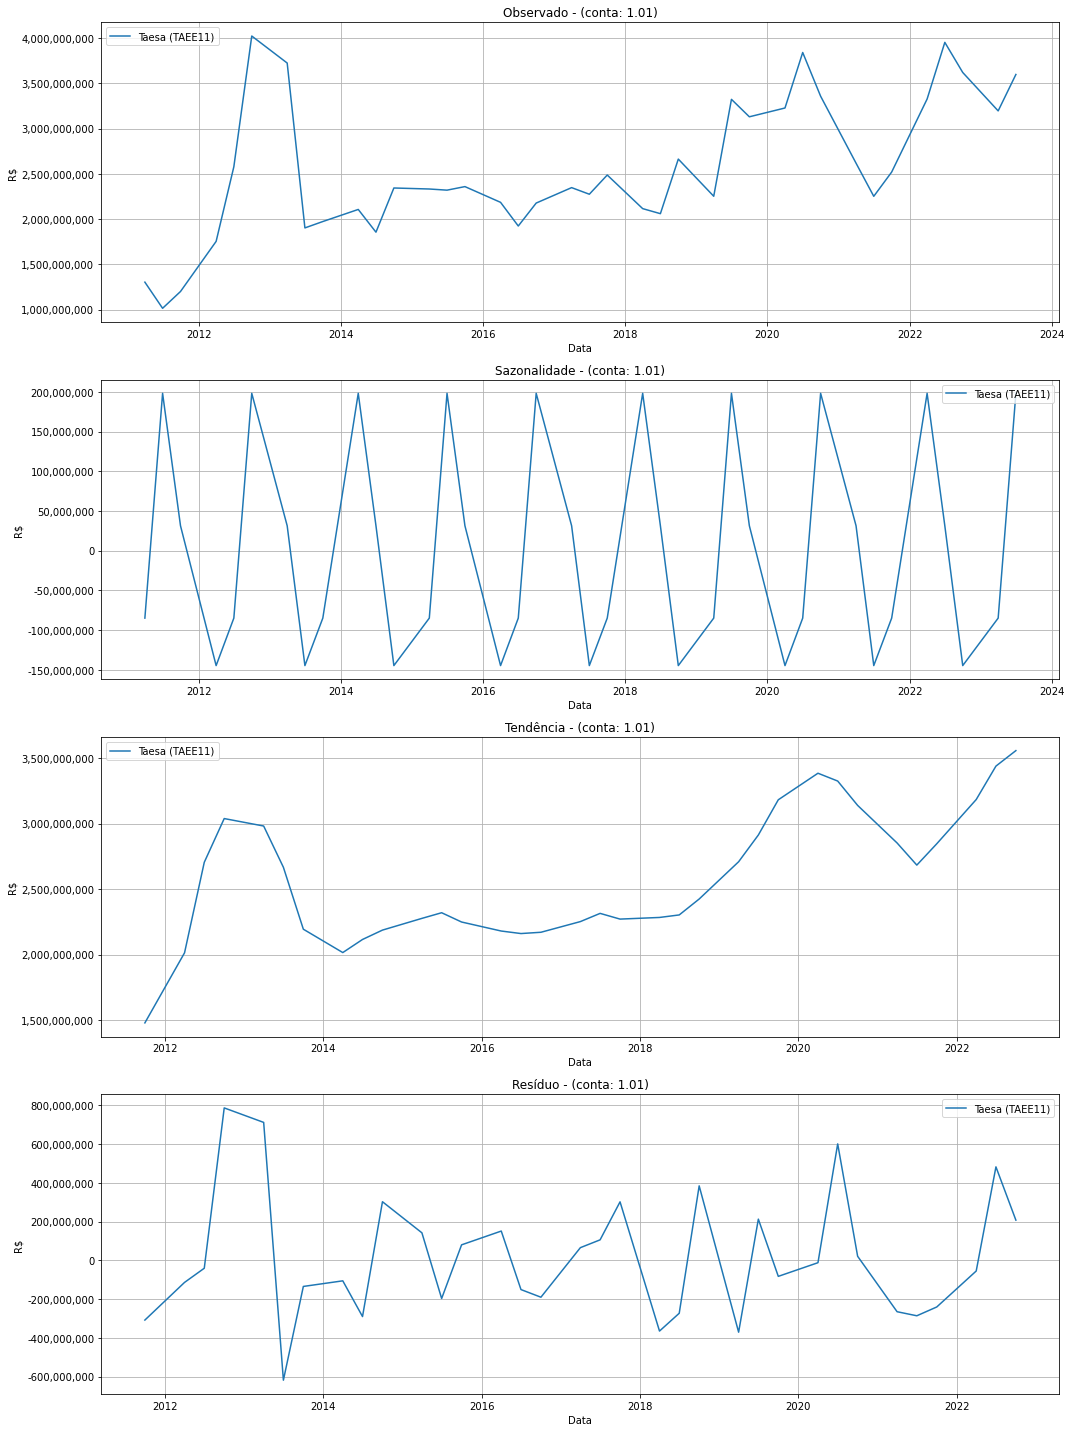


Checking if 1.01 is stationary
ADF Statistic: -2.5240617231860605
ADF p-value: 0.10972906644591796
Conclusion: The time series is NOT stationary

account
{'code': '1.01', 'stationary': False, 'diff_count': 0}




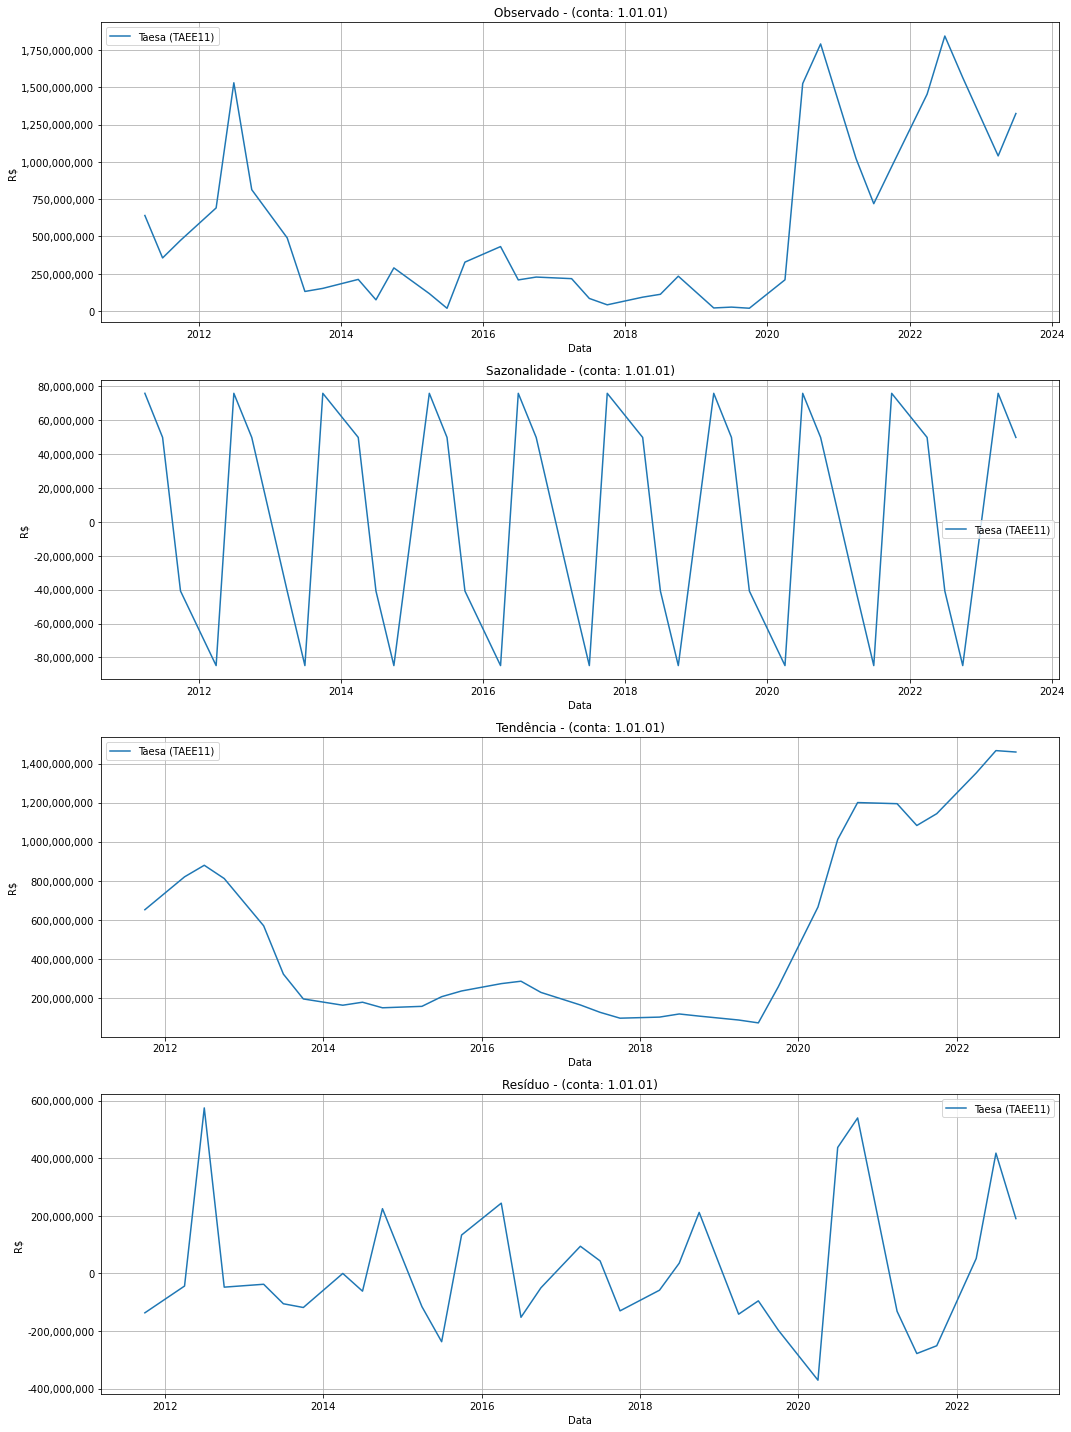


Checking if 1.01.01 is stationary
ADF Statistic: -0.44088820994314654
ADF p-value: 0.9030448295476938
Conclusion: The time series is NOT stationary

account
{'code': '1.01.01', 'stationary': False, 'diff_count': 0}




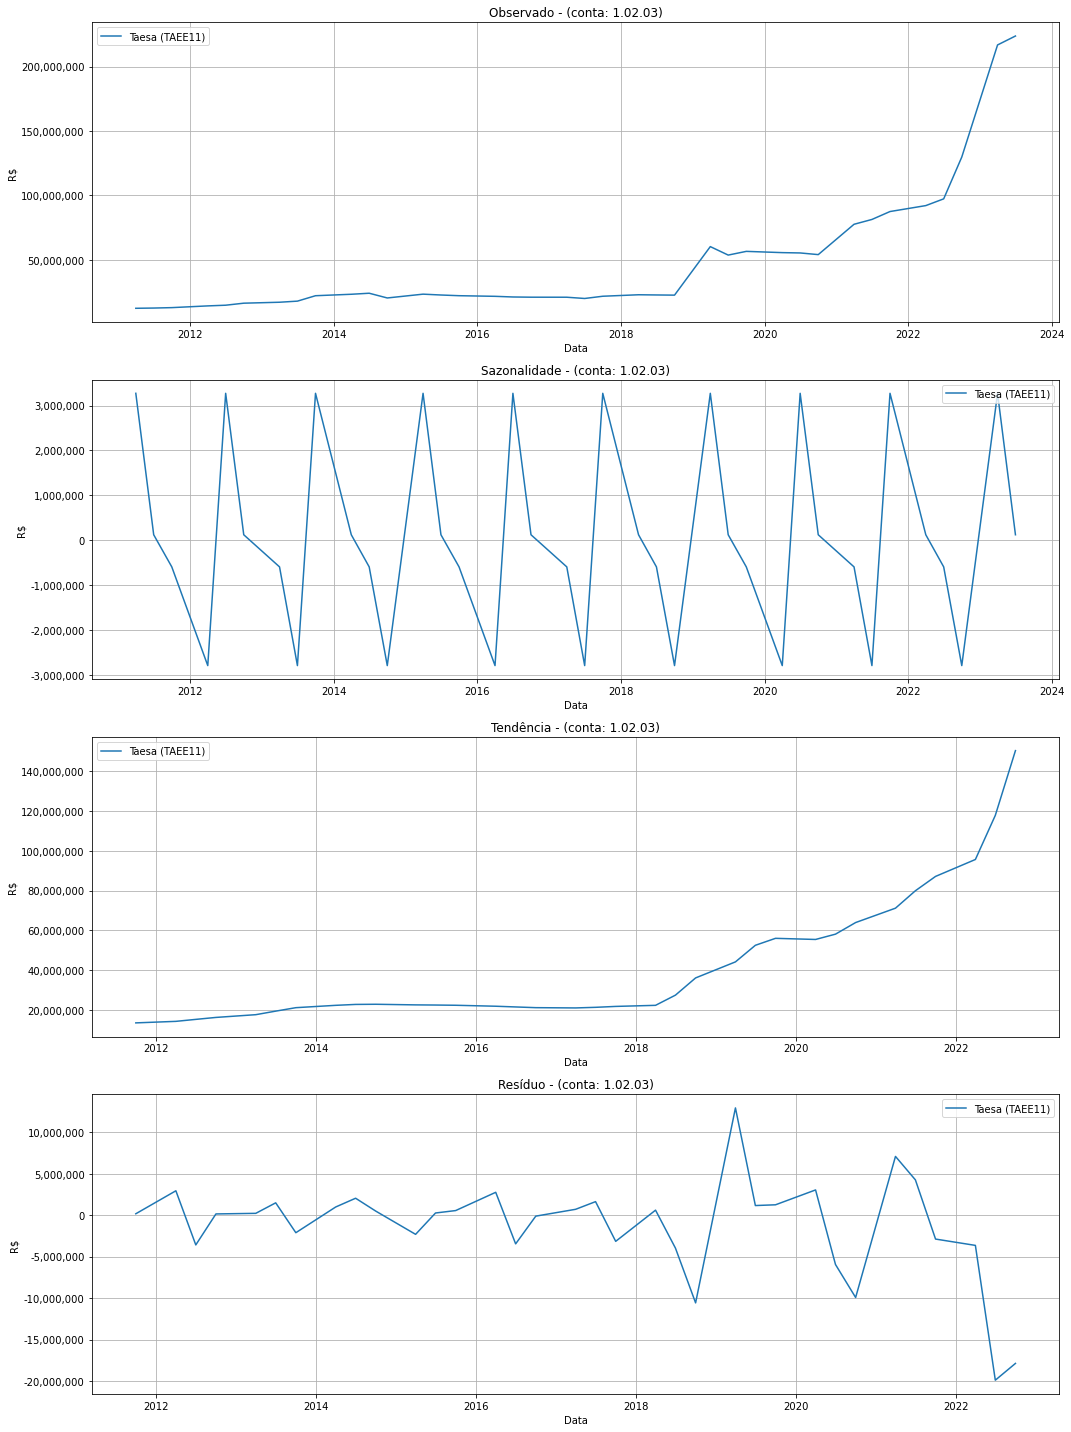


Checking if 1.02.03 is stationary
ADF Statistic: 3.7724502564448223
ADF p-value: 1.0
Conclusion: The time series is NOT stationary

account
{'code': '1.02.03', 'stationary': False, 'diff_count': 0}




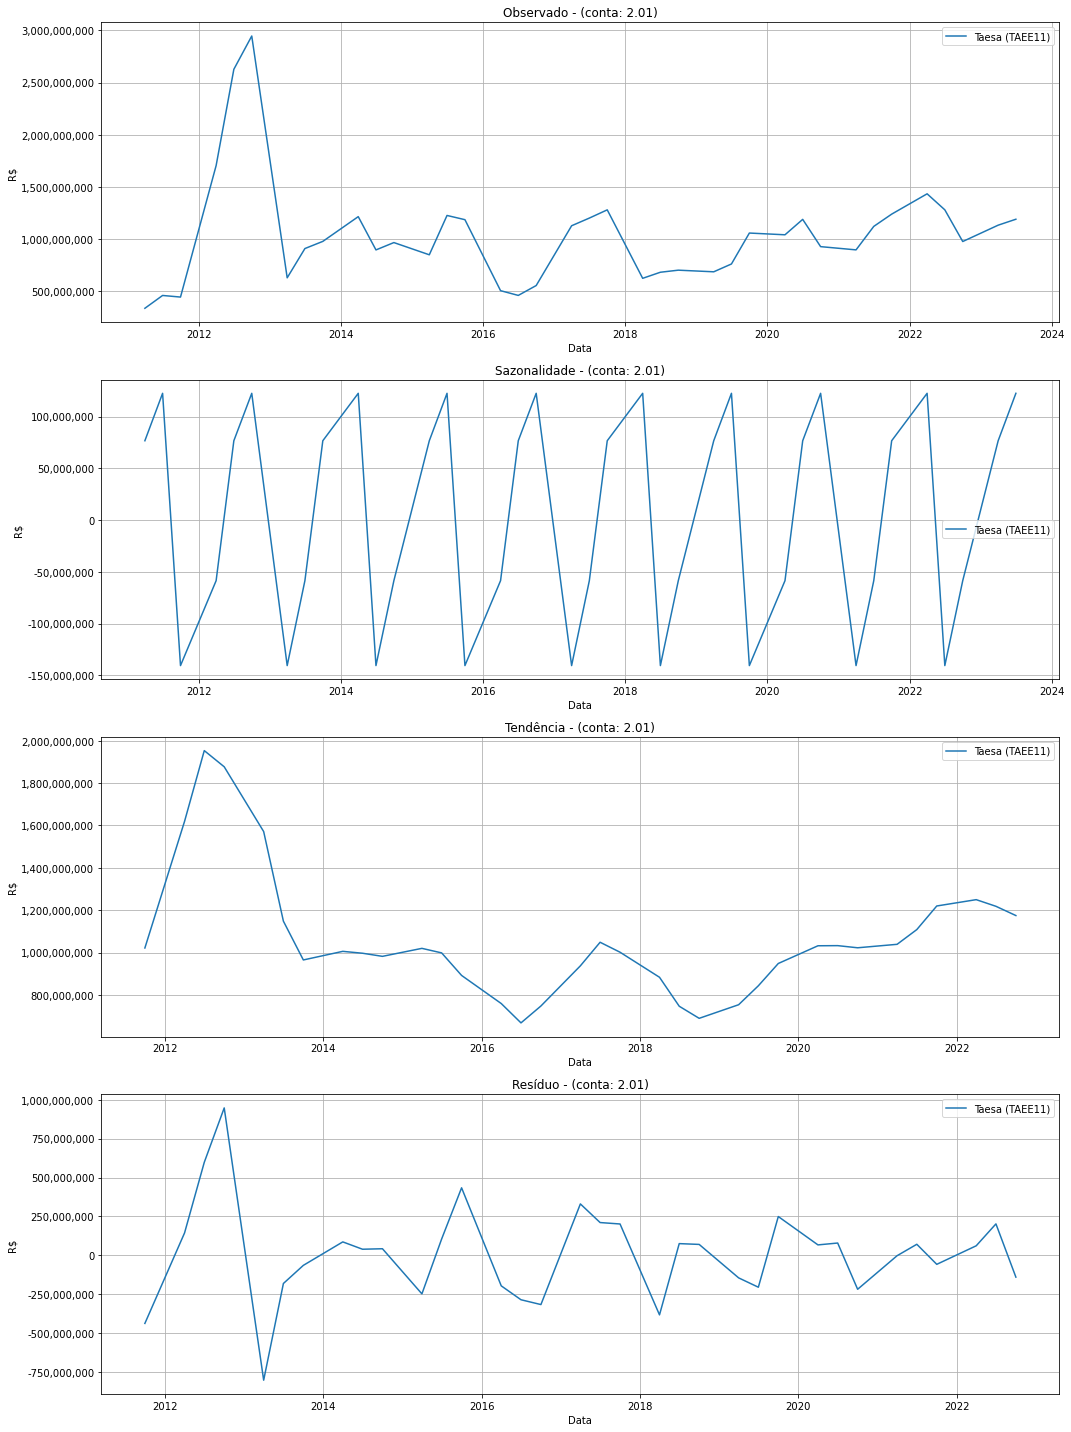


Checking if 2.01 is stationary
ADF Statistic: -2.101012922202895
ADF p-value: 0.2441074955129125
Conclusion: The time series is NOT stationary

account
{'code': '2.01', 'stationary': False, 'diff_count': 0}



Checking if 2.01.03 is stationary
ADF Statistic: -3.6745796985283388
ADF p-value: 0.004485258456553979
Conclusion: The time series is stationary

account
{'code': '2.01.03', 'stationary': True, 'diff_count': 0}



Checking if 2.01.04 is stationary
ADF Statistic: -2.796039411044252
ADF p-value: 0.058841740922901696
Conclusion: The time series is NOT stationary

account
{'code': '2.01.04', 'stationary': False, 'diff_count': 0}



Checking if 2.02.01 is stationary
ADF Statistic: 0.51626276779643
ADF p-value: 0.9853590975005982
Conclusion: The time series is NOT stationary

account
{'code': '2.02.01', 'stationary': False, 'diff_count': 0}



Checking if 3.11 is stationary
ADF Statistic: -2.9910162594886063
ADF p-value: 0.035741928590166214
Conclusion: The time series is stationary



In [37]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def print_graph(size, index, data, company, title, account):
    plt.subplot(size, 1, index)
    plt.plot(data, label=f"{company['name']} ({company['ticker']})")
    plt.title(f"{title} - (conta: {account['code']})")
    plt.xlabel('Data')
    plt.ylabel('R$')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(True)

def check_stationarity(data, code):
    print(f'\nChecking if {code} is stationary')
    # Performing the Augmented Dickey-Fuller test:
    adf_result = adfuller(data)
    adf_statistic, adf_p_value = adf_result[0], adf_result[1]
    print('ADF Statistic:', adf_statistic)
    print('ADF p-value:', adf_p_value)

    is_stationary = adf_p_value <= P_VALUE
    if is_stationary:
        print("Conclusion: The time series is stationary")
    else:
        print("Conclusion: The time series is NOT stationary")
    return is_stationary

def decompose_and_print(df, accounts):
    for company_code in companies:
        company_data = df[df['CD_CVM'] == company_code]
        company = companies[company_code]

        count = 0
        for account_key in accounts:
            count += 1
            account = accounts[account_key]

            # 4 = quarter division
            decomposition = seasonal_decompose(company_data[account_key], model='additive', period=4)

            if (count < 5):
                plt.figure(figsize=(15, 20))
                print_graph(4, 1, decomposition.observed, company, 'Observado', account)
                print_graph(4, 2, decomposition.seasonal, company, 'Sazonalidade', account)
                print_graph(4, 3, decomposition.trend, company, 'Tendência', account)
                print_graph(4, 4, decomposition.resid, company, 'Resíduo', account)
                plt.tight_layout()
                plt.grid(True)
                plt.show()

            account['stationary'] = check_stationarity(company_data[account_key], account['code'])

            print('\naccount')
            print(account)
            print('\n')

# reading data
df = read_csv('pivot', index_col="DT_REFER")

decompose_and_print(df, accounts_to_calculate_fcfe)


#### 5.1.2 Making non-stationary series stationary


-----------------------------------------------------------------

company_code: 20257

..... ..... ..... ..... .....
account_key: VL_CONTA_1.01
account: {'code': '1.01', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '1.01', 'stationary': False, 'diff_count': 0}


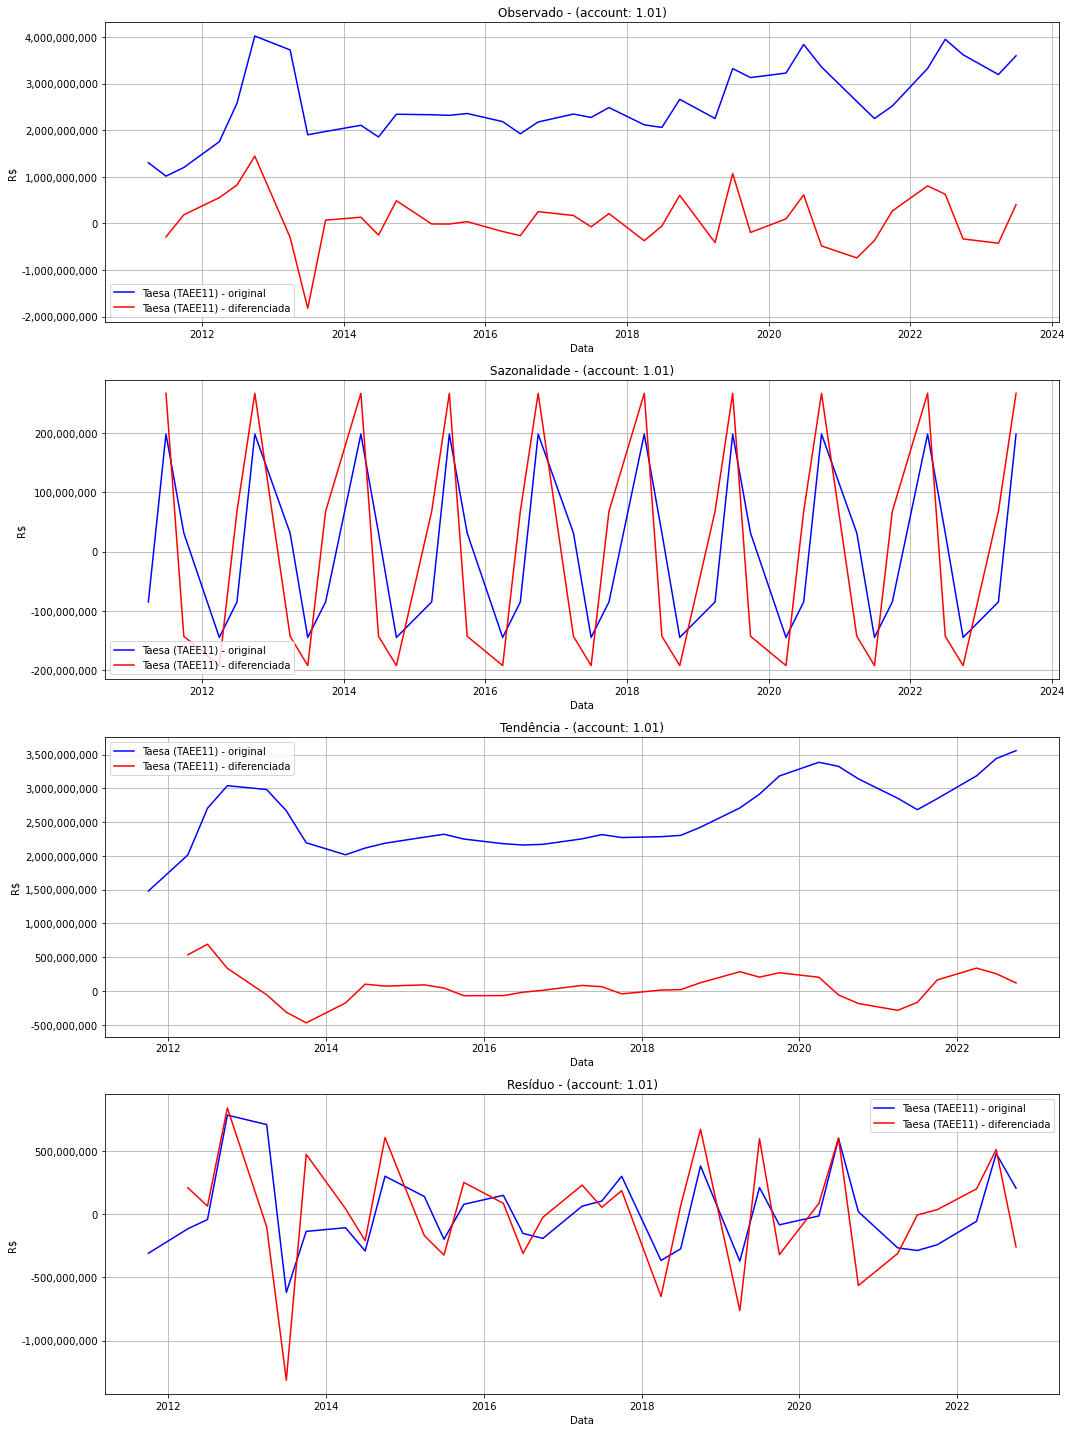


Checking if 1.01 is stationary
ADF Statistic: -5.306825035892374
ADF p-value: 5.300192743753107e-06
Conclusion: The time series is stationary

 after differentiation
{'code': '1.01', 'stationary': True, 'diff_count': 1}

..... ..... ..... ..... .....
account_key: VL_CONTA_1.01.01
account: {'code': '1.01.01', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '1.01.01', 'stationary': False, 'diff_count': 0}


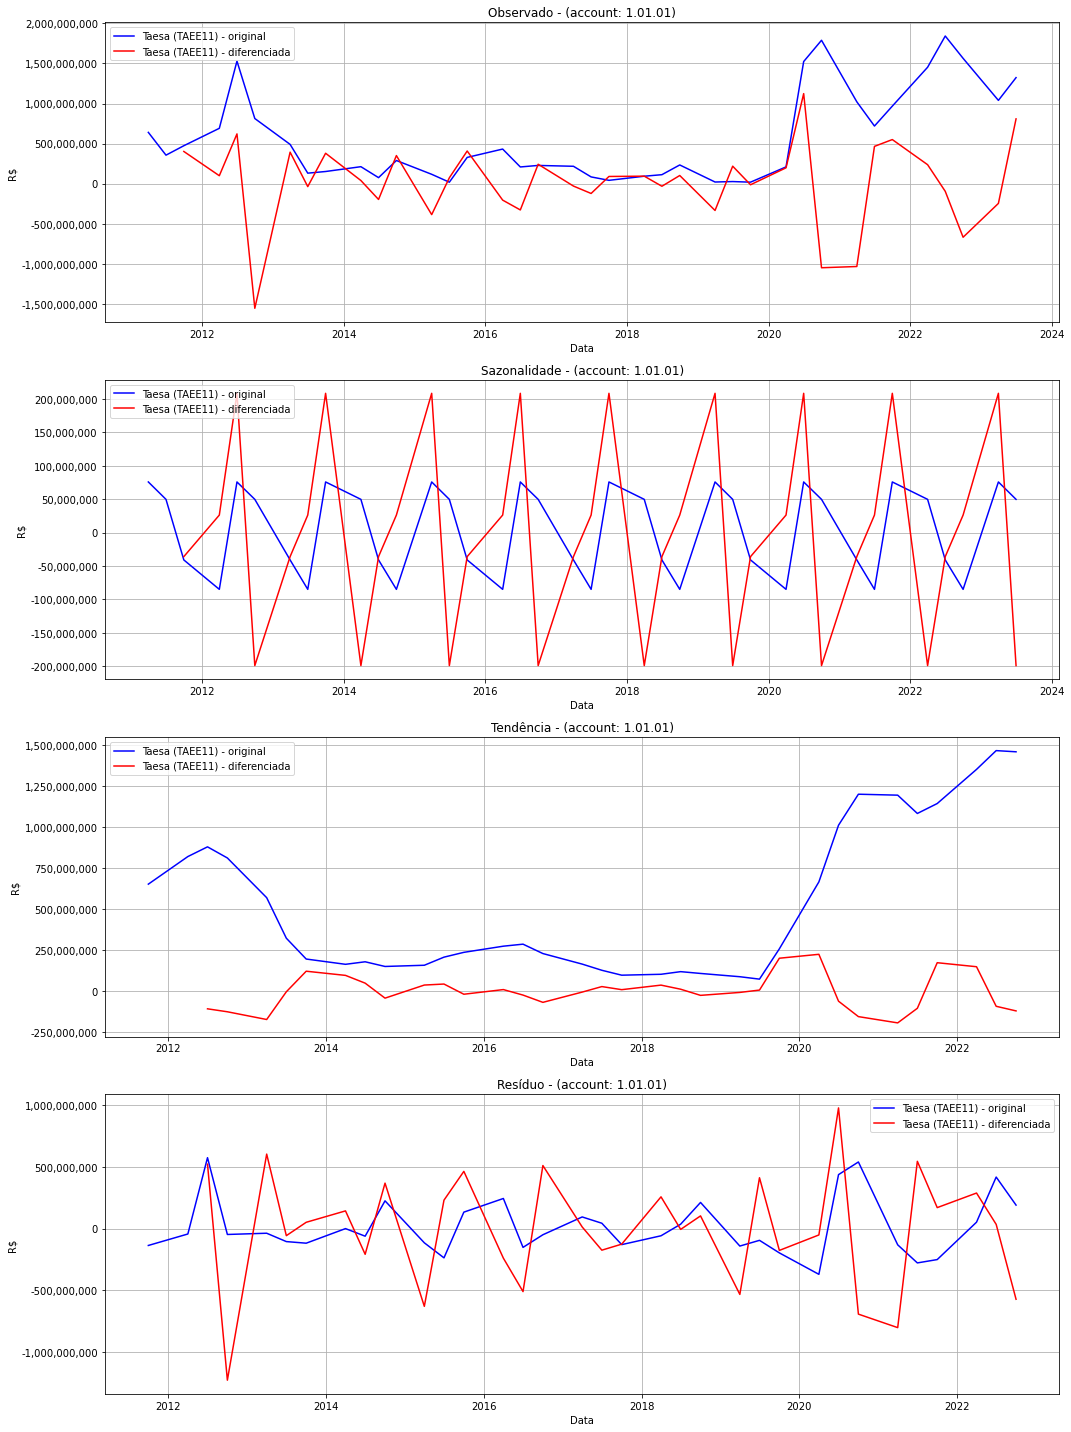


Checking if 1.01.01 is stationary
ADF Statistic: -6.862711375704869
ADF p-value: 1.5874270525949579e-09
Conclusion: The time series is stationary

 after differentiation
{'code': '1.01.01', 'stationary': True, 'diff_count': 2}

..... ..... ..... ..... .....
account_key: VL_CONTA_1.02.03
account: {'code': '1.02.03', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '1.02.03', 'stationary': False, 'diff_count': 0}


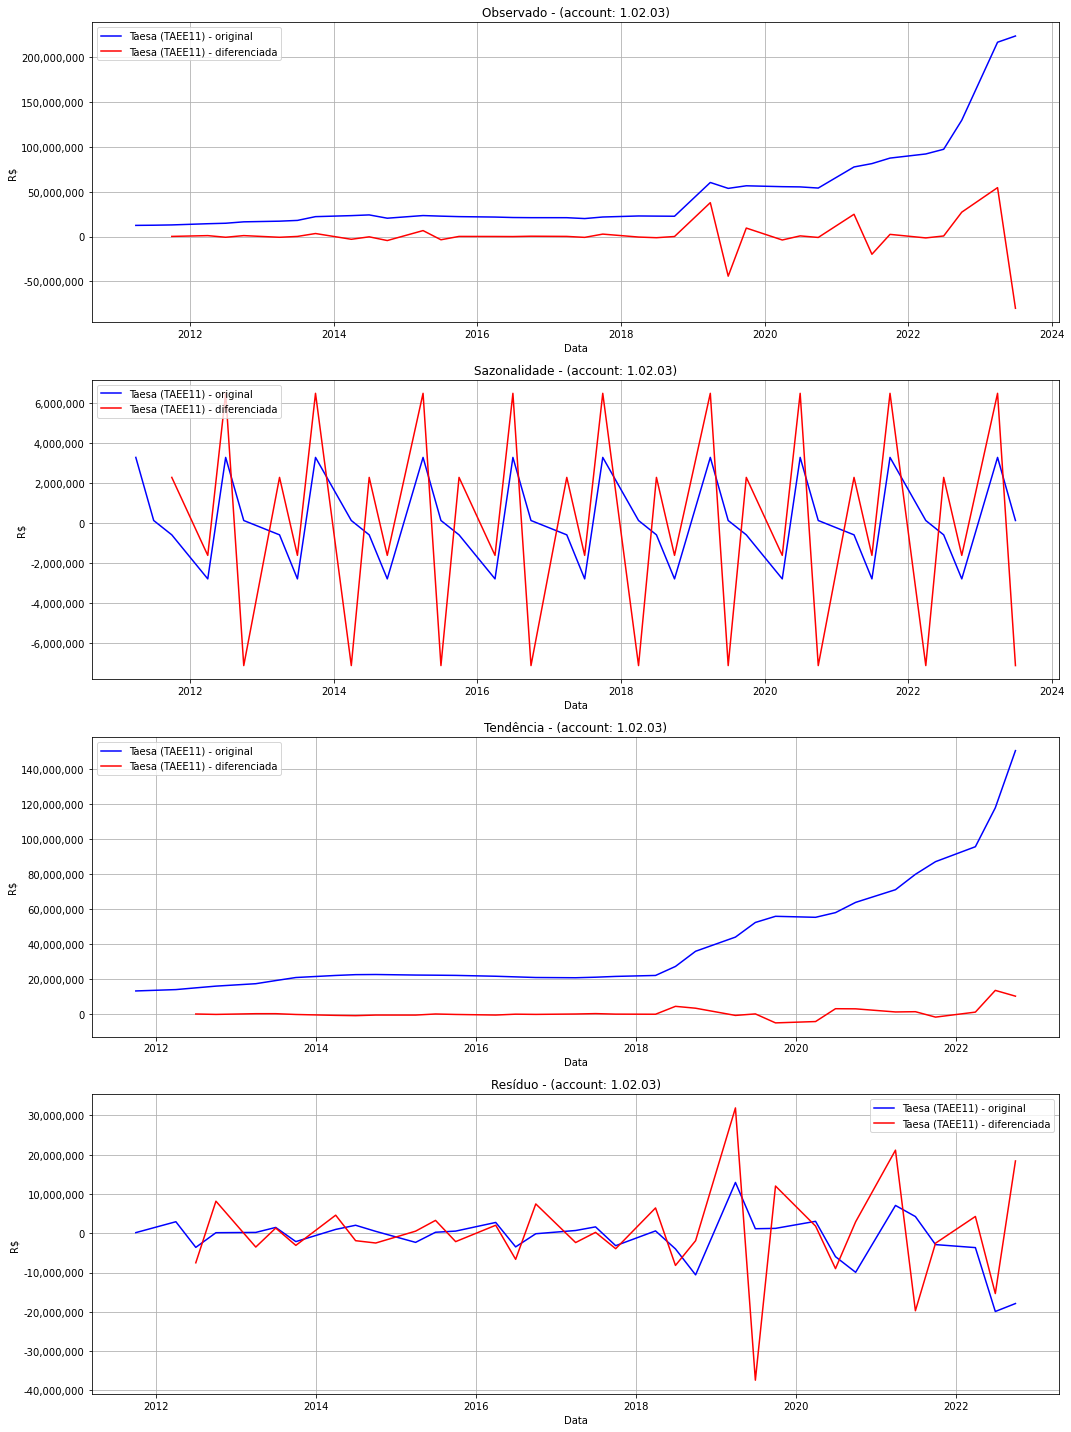


Checking if 1.02.03 is stationary
ADF Statistic: -3.11353793326558
ADF p-value: 0.02556740799758976
Conclusion: The time series is stationary

 after differentiation
{'code': '1.02.03', 'stationary': True, 'diff_count': 2}

..... ..... ..... ..... .....
account_key: VL_CONTA_2.01
account: {'code': '2.01', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '2.01', 'stationary': False, 'diff_count': 0}


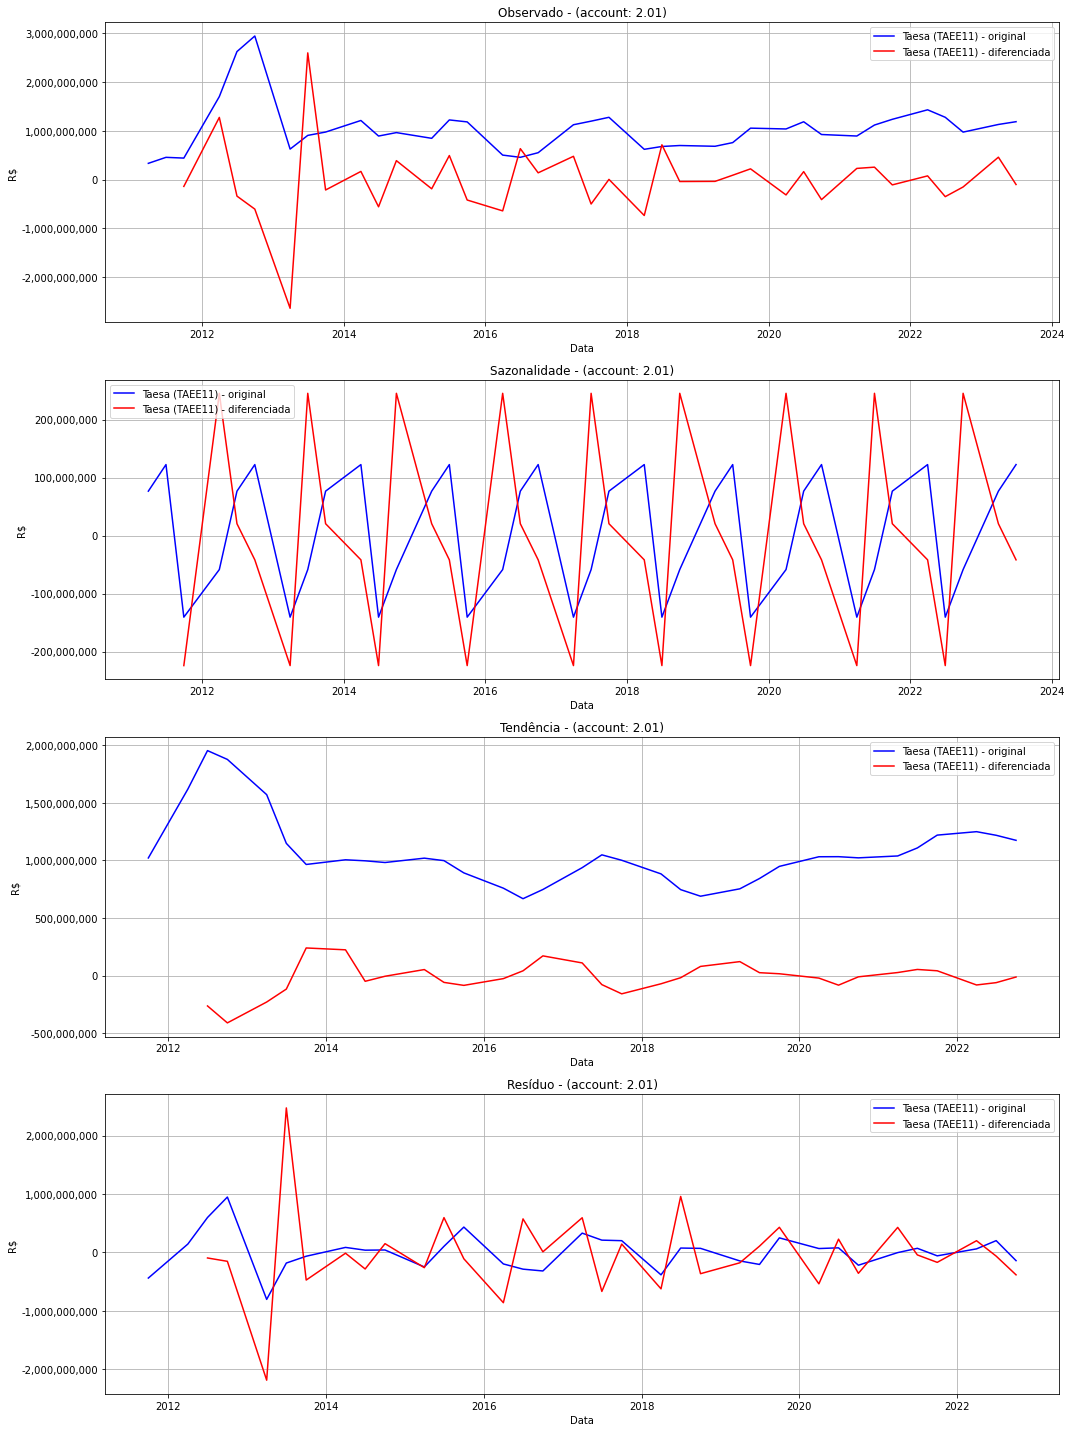


Checking if 2.01 is stationary
ADF Statistic: -7.776214418430882
ADF p-value: 8.655524099270813e-12
Conclusion: The time series is stationary

 after differentiation
{'code': '2.01', 'stationary': True, 'diff_count': 2}

..... ..... ..... ..... .....
account_key: VL_CONTA_2.01.03
account: {'code': '2.01.03', 'stationary': True, 'diff_count': 0}

..... ..... ..... ..... .....
account_key: VL_CONTA_2.01.04
account: {'code': '2.01.04', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '2.01.04', 'stationary': False, 'diff_count': 0}

Checking if 2.01.04 is stationary
ADF Statistic: -7.994044955722799
ADF p-value: 2.4310268925590994e-12
Conclusion: The time series is stationary

 after differentiation
{'code': '2.01.04', 'stationary': True, 'diff_count': 2}

..... ..... ..... ..... .....
account_key: VL_CONTA_2.02.01
account: {'code': '2.02.01', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '2.02.01', 'stationary': False, 'diff_count': 0}

C

In [38]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series):
    result = adfuller(series)
    return result[1] <= P_VALUE

def make_series_stationary(series, account, max_diff=5):
    stationary_series = series.copy()
    for _ in range(max_diff):
        stationary_series = stationary_series.diff().dropna()
        # increment differentiations
        account['diff_count'] += 1
        if adfuller_test(stationary_series):
            return stationary_series
    return None

def print_graph(size, index, data_original, data, company, title, account):
    plt.subplot(size, 1, index)
    plt.plot(data_original, label=f"{company['name']} ({company['ticker']}) - original", color='blue')
    plt.plot(data, label=f"{company['name']} ({company['ticker']}) - diferenciada", color='red')
    plt.title(f"{title} - (account: {account['code']})")
    plt.xlabel('Data')
    plt.ylabel('R$')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(True)

def make_series_stationary_and_print(df_original, df, accounts):
    df_updated = df.copy()
    for company_code in companies:
        print('\n-----------------------------------------------------------------\n')
        print(f'company_code: {company_code}')

        company = companies[company_code]

        company_data_original = df_original[df_original['CD_CVM'] == company_code].copy()
        company_data = df_updated[df_updated['CD_CVM'] == company_code].copy()

        count = 0
        for account_key in accounts:
            count += 1
            print("\n..... ..... ..... ..... .....")
            account = accounts[account_key]
            print(f'account_key: {account_key}')
            print(f'account: {account}')

            if (not account['stationary']):
                account_data_original = company_data_original[account_key].copy()
                account_data = company_data[account_key].copy()

                # Making the series stationary
                print('\n before differentiation')
                print(account)
                account_data = make_series_stationary(account_data, account)
                decomposition_original = seasonal_decompose(account_data_original, model='additive', period=4)
                decomposition = seasonal_decompose(account_data, model='additive', period=4)

                if (count < 5):
                    plt.figure(figsize=(15, 20))
                    print_graph(4, 1, decomposition_original.observed, decomposition.observed, company, 'Observado', account)
                    print_graph(4, 2, decomposition_original.seasonal, decomposition.seasonal, company, 'Sazonalidade', account)
                    print_graph(4, 3, decomposition_original.trend, decomposition.trend, company, 'Tendência', account)
                    print_graph(4, 4, decomposition_original.resid, decomposition.resid, company, 'Resíduo', account)
                    plt.tight_layout()
                    plt.grid(True)
                    plt.show()

                account['stationary'] = check_stationarity(account_data, account['code'])
                company_data[account_key] = account_data

                print('\n after differentiation')
                print(account)

        df_updated.loc[df_updated['CD_CVM'] == company_code, :] = company_data

    return df_updated

# reading data
df = read_csv('pivot', index_col="DT_REFER")

original_indices = df.index.tolist()

df_result = df.copy()
df_result = make_series_stationary_and_print(df, df_result, accounts_to_calculate_fcfe)

print("\n----- ----- ----- ----- ----- ----- ----- ----- ----- -----")
print('df_result')
print(df_result)

print("\n----- ----- ----- ----- ----- ----- ----- ----- ----- -----")
print('accounts_to_calculate_fcfe')
print(accounts_to_calculate_fcfe)

saveToFile('stationary', df_result, setIndex=False, verbose=False)
saveToFile('stationary_drop_na', df_result.dropna(), setIndex=False, verbose=False)


### 5.2 Modeling


#### 5.2.1 Modeling common functions

In [39]:
import numpy as np

DATE_CUTOFF = '2023-01-01'
END_DATE = '2024-12-31'

def accuracy(y_true, y_pred):
    """
    Calculate the accuracy based on Mean Absolute Percentage Error (MAPE).
    
    Args:
    - y_true: Array-like of true values.
    - y_pred: Array-like of predicted values.
    
    Returns:
    - accuracy: Accuracy percentage.
    """
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return 100 - mape

def calculate_accuracy(y_train, y_test, pred_train, pred_test):
    """
    Calculate the accuracy for training and testing data.
    
    Args:
    - y_train: Array-like of training true values.
    - y_test: Array-like of testing true values.
    - pred_train: Array-like of training predicted values.
    - pred_test: Array-like of testing predicted values.
    
    Returns:
    - train_accuracy: Accuracy of the training predictions.
    - test_accuracy: Accuracy of the testing predictions.
    """
    train_accuracy = accuracy(y_train, pred_train)
    test_accuracy = accuracy(y_test, pred_test)
    
    print(f'\n-> Calculando a Acurácia')
    print(f'Acurácia de Treinamento: {train_accuracy:.2f}%')
    print(f'Acurácia de Teste: {test_accuracy:.2f}%\n')
    
    return train_accuracy, test_accuracy

def train_test_split(df, account):
    """
    Split the data into training and testing sets based on the DATE_CUTOFF.
    """
    print('\n-> Separating data in trainning and testing groups')
    train = df[df.index < DATE_CUTOFF]
    test = df[(df.index >= DATE_CUTOFF) & (df.index <= END_DATE)]

    X_train = train.drop(columns=[account, 'CD_CVM'])
    y_train = train[account]
    X_test = test.drop(columns=[account, 'CD_CVM'])
    y_test = test[account]

    y_train = y_train.dropna()
    X_train = X_train.loc[y_train.index]
    return train,test,X_train,y_train,X_test,y_test

def handle_missing_values(df):
    """
    Handle missing values in the DataFrame by forward and backward filling.
    
    Args:
    - df: Input DataFrame.
    
    Returns:
    - df: DataFrame with missing values handled.
    """
    return df.fillna(method='ffill').fillna(method='bfill')

def plot_graph(algorithm, company, ax, idx, account, y_train, y_test, pred_train, pred_test, train_accuracy, test_accuracy):
    """
    Plot the real vs predicted values.
    """
    print(f'\n-> Plotting graph')
    
    # Combining real and predicted values for a continuous plot
    combined_real = pd.concat([y_train, y_test])
    combined_pred = pd.concat([pd.Series(pred_train, index=y_train.index), pd.Series(pred_test, index=y_test.index)])

    ax[idx].plot(combined_real.index, combined_real, label='Real', color='blue')
    ax[idx].plot(combined_pred.index, combined_pred, linestyle='--', label='Predicted', color='red')
    ax[idx].set_title(f"[[ {algorithm} ]] | ( {company['name'] }: {company['ticker']}) | {account} | Train accuracy: {train_accuracy:.2f}% | Test accuracy: {test_accuracy:.2f}%")
    ax[idx].set_ylabel('R$')
    ax[idx].legend(loc='best')
    ax[idx].ticklabel_format(style='plain', axis='y')
    ax[idx].yaxis.set_major_formatter(formatter)
    ax[idx].grid(True)



#### 5.2.2 GLM


-----------------------------------------------------------------

company_code: 20257

Training........................................
company: {'name': 'Taesa', 'ticker': 'TAEE11'}
idx: 0
account: VL_CONTA_1.01

-> Separating data in trainning and testing groups

-> Selecting features with step-wise
Adicionando VL_CONTA_6.03 com p-value 0.0
Adicionando VL_CONTA_2.02.01 com p-value 0.0
Adicionando VL_CONTA_PENULTIMO_6.01 com p-value 3.32346e-182
Adicionando VL_CONTA_PENULTIMO_2.02.01 com p-value 1.76192e-228
Adicionando VL_CONTA_6.01 com p-value 2.62822e-211
Adicionando VL_CONTA_PENULTIMO_1.02.03 com p-value 2.35096e-302
Adicionando VL_CONTA_1.02.03 com p-value 2.19729e-153
Adicionando VL_CONTA_PENULTIMO_2.01.03 com p-value 5.85259e-155
Adicionando VL_CONTA_PENULTIMO_1.01 com p-value 1.17237e-96
Adicionando VL_CONTA_2.01.04 com p-value 4.54898e-69
Adicionando VL_CONTA_PENULTIMO_2.01.04 com p-value 3.38616e-98
Removendo VL_CONTA_2.02.01 com p-value 0.570702
Adicionando VL_CONTA_7.04.

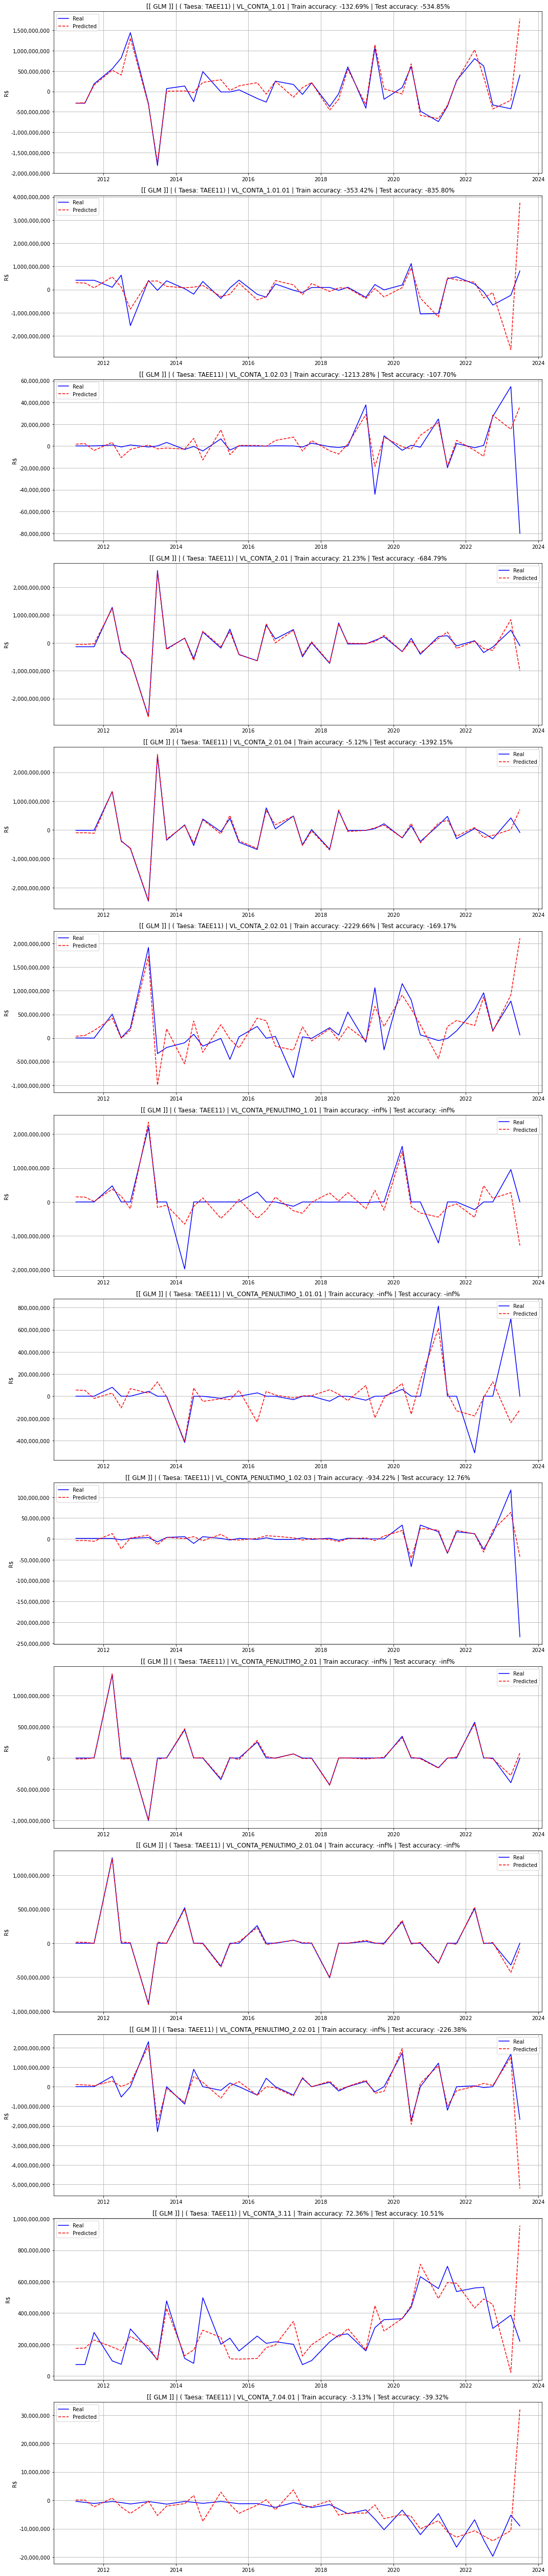


-----------------------------------------------------------------
saving file: df_glm.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4475 entries, 2011-03-31 to 2023-06-30
Freq: D
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CD_CVM                               4475 non-null   float64
 1   VL_CONTA_1.01                        4475 non-null   float64
 2   VL_CONTA_1.01.01                     4475 non-null   float64
 3   VL_CONTA_1.02.03                     4475 non-null   float64
 4   VL_CONTA_2.01                        4475 non-null   float64
 5   VL_CONTA_2.01.03                     4475 non-null   float64
 6   VL_CONTA_2.01.04                     4475 non-null   float64
 7   VL_CONTA_2.02.01                     4475 non-null   float64
 8   VL_CONTA_3.11                        4475 non-null   float64
 9   VL_CONTA_6.01                  

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def stepwise_feature_selection(X, y, X_test, initial_list=[], threshold_in=0.01, threshold_out = 0.05, verbose=True):
    """
    Stepwise feature selection based on p-values.
    
    Args:
    - X: DataFrame of predictor variables.
    - y: Series of response variable.
    - initial_list: List of initial features to include.
    - threshold_in: P-value threshold for feature inclusion.
    - threshold_out: P-value threshold for feature removal.
    - verbose: If True, prints progress messages.
    
    Returns:
    - included: List of selected features.
    """
    print(f'\n-> Selecting features with step-wise')
    included = list(initial_list)

    while True:
        changed = False

        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(dtype='float64', index=excluded)

        for new_column in excluded:
            model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Adicionando {best_feature} com p-value {best_pval:.6}')

        # backward step
        model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Removendo {worst_feature} com p-value {worst_pval:.6}')
        if not changed:
            break

    X = X[included]
    X_test = X_test[included]
    return X, X_test

def train_glm(X_train, y_train):
    """
    Train the Generalized Linear Model (GLM).
    """
    print(f'\n-> Trainning GLM model')
    model = sm.GLM(y_train, sm.add_constant(X_train)).fit()
    return model

def make_predictions(X_train, X_test, model):
    """
    Make predictions using the trained model.
    """
    print(f'\n-> Doing predictions')
    pred_train = model.predict(sm.add_constant(X_train))
    pred_test = model.predict(sm.add_constant(X_test))
    return pred_train,pred_test

def update_predictions(results_df, account, train, test, pred_train, pred_test):
    print(f'\n-> Updating predictions into DataFrame')
    results_df.loc[train.index, f'{account}_pred_glm'] = pred_train
    results_df.loc[test.index, f'{account}_pred_glm'] = pred_test

def train_forecast_account(company, df, results_df, ax, idx, account):
    """
    Train the forecasting model for a specific account and visualize the results.
    """
    print(f'\nTraining........................................')
    print(f'company: {company}')
    print(f'idx: {idx}')
    print(f'account: {account}')

    train, test, X_train, y_train, X_test, y_test = train_test_split(df, account)

    X_train, X_test = stepwise_feature_selection(X_train, y_train, X_test)

    model = train_glm(X_train, y_train)

    pred_train, pred_test = make_predictions(X_train, X_test, model)

    train_accuracy, test_accuracy = calculate_accuracy(y_train, y_test, pred_train, pred_test)

    update_predictions(results_df, account, train, test, pred_train, pred_test)

    plot_graph('GLM', company, ax, idx, account, y_train, y_test, pred_train, pred_test, train_accuracy, test_accuracy)

if __name__ == "__main__":
    # Load and preprocess data
    df = read_csv('stationary', index_col='DT_REFER', frequency='D', interpolate=True)
    df = handle_missing_values(df)
    results_df = df.copy()

    for company_code in companies:
        print('\n-----------------------------------------------------------------\n')
        print(f'company_code: {company_code}')

        company = companies[company_code]
        company_data = results_df[results_df['CD_CVM'] == company_code]

        # Train and visualize
        fig, ax = plt.subplots(len(columns_to_forecast), 1, figsize=(15, 5 * len(columns_to_forecast)))
        for idx, account in enumerate(columns_to_forecast):
            train_forecast_account(company, df, results_df, ax, idx, account)
        plt.tight_layout()
        plt.show()

    saveToFile('glm', results_df, setIndex=False)


#### 5.2.3 ARIMAX (with exogenous variables - multivariable)


-----------------------------------------------------------------

company_code: 20257

Training........................................
company: {'name': 'Taesa', 'ticker': 'TAEE11'}
idx: 0
account: VL_CONTA_1.01

-> Separating data in trainning and testing groups

-> Training ARIMAX model with starting differencing order 1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=161000.604, Time=8.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=147133.128, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=179157.303, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=144917.513, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=147131.170, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=161254.791, Time=1.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=144451.601, Time=1.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=161106.055, Time=3.72 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=144193.206, Time=6.06 sec
 ARIMA(1,1,3)(0,0

/home/enok/.local/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,1,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/home/enok/.local/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/home/enok/.local/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/home/enok/.local/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "/home/enok/.local/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py", line 704

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=14.39 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=26.31 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 278.136 seconds

-> Doing predictions

-> Calculando a Acurácia
Acurácia de Treinamento: 99.92%
Acurácia de Teste: 59.45%


-> Updating predictions into DataFrame

-> Plotting graph


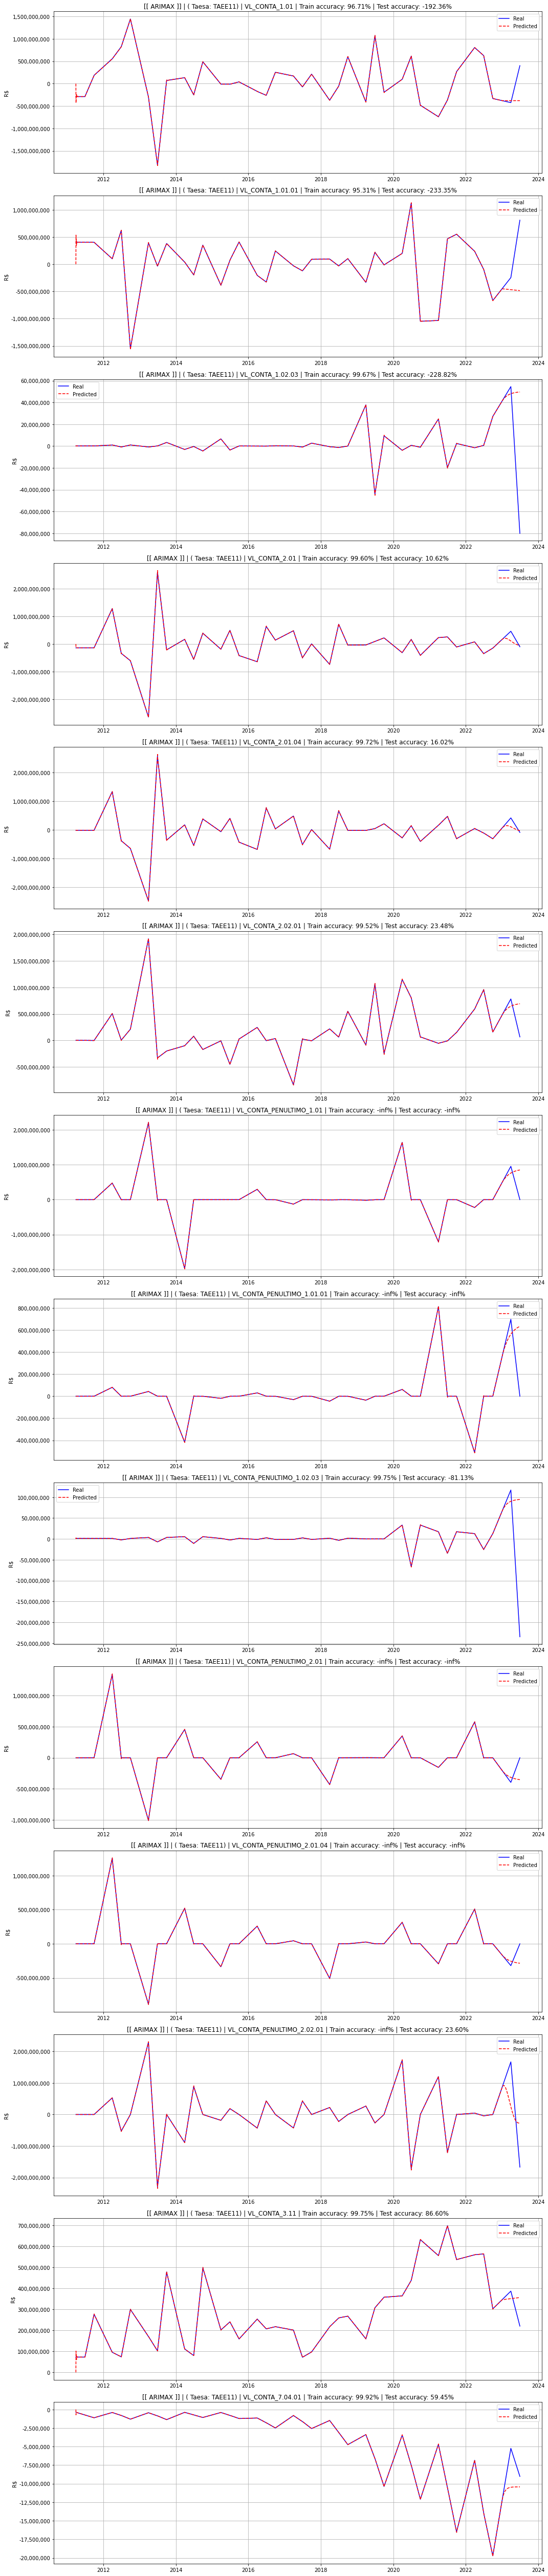


-----------------------------------------------------------------
saving file: df_arimax.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4475 entries, 2011-03-31 to 2023-06-30
Freq: D
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   CD_CVM                                  4475 non-null   float64
 1   VL_CONTA_1.01                           4475 non-null   float64
 2   VL_CONTA_1.01.01                        4475 non-null   float64
 3   VL_CONTA_1.02.03                        4475 non-null   float64
 4   VL_CONTA_2.01                           4475 non-null   float64
 5   VL_CONTA_2.01.03                        4475 non-null   float64
 6   VL_CONTA_2.01.04                        4475 non-null   float64
 7   VL_CONTA_2.02.01                        4475 non-null   float64
 8   VL_CONTA_3.11                           4475 non-null   float64


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

def train_arimax(X_train, y_train, start_diff):
    """
    Train the ARIMAX model using auto_arima.
    """
    print(f'\n-> Training ARIMAX model with starting differencing order {start_diff}')
    model = auto_arima(y_train, exogenous=X_train, seasonal=False, trace=True, stepwise=True)
    model_fit = model.fit(y_train, exogenous=X_train)
    return model_fit

def make_predictions(model_fit, X_train, X_test, n_forecast):
    """
    Make predictions using the trained ARIMAX model.
    """
    print(f'\n-> Doing predictions')
    pred_train = model_fit.predict_in_sample(exogenous=X_train)
    pred_test = model_fit.predict(n_periods=n_forecast, exogenous=X_test)
    return pred_train, pred_test

def update_predictions(results_df, account, train, test, pred_train, pred_test):
    print(f'\n-> Updating predictions into DataFrame')
    results_df.loc[train.index, f'{account}_pred_arimax'] = pred_train
    results_df.loc[test.index, f'{account}_pred_arimax'] = pred_test

def train_forecast_account(company, df, results_df, ax, idx, account):
    """
    Train the forecasting model for a specific account and visualize the results.
    """
    print(f'\nTraining........................................')
    print(f'company: {company}')
    print(f'idx: {idx}')
    print(f'account: {account}')

    train, test, X_train, y_train, X_test, y_test = train_test_split(df, account)
    start_diff = accounts_to_calculate_fcfe[account]["diff_count"]
    
    model_fit = train_arimax(X_train, y_train, start_diff)

    pred_train, pred_test = make_predictions(model_fit, X_train, X_test, len(y_test))

    train_accuracy, test_accuracy = calculate_accuracy(y_train, y_test, pred_train, pred_test)

    update_predictions(results_df, account, train, test, pred_train, pred_test)

    plot_graph('ARIMAX', company, ax, idx, account, y_train, y_test, pred_train, pred_test, train_accuracy, test_accuracy)

if __name__ == "__main__":
    # Load and preprocess data
    df = read_csv('stationary', index_col='DT_REFER', frequency='D', interpolate=True)
    df = handle_missing_values(df)
    results_df = df.copy()

    for company_code in companies:
        print('\n-----------------------------------------------------------------\n')
        print(f'company_code: {company_code}')

        company = companies[company_code]
        company_data = results_df[results_df['CD_CVM'] == company_code]

        # Train and visualize
        fig, ax = plt.subplots(len(columns_to_forecast), 1, figsize=(15, 5 * len(columns_to_forecast)))
        for idx, account in enumerate(columns_to_forecast):
            train_forecast_account(company, df, results_df, ax, idx, account)
        plt.tight_layout()
        plt.show()

saveToFile('arimax', results_df, setIndex=False)

### 5.3 Calculating Free Cash Flow

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>


*3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE) = <br>
  LUCRO_LIQUIDO_PERIODO*<br>


*Δ 1.02.03 (Imobilizado) = <br>
  IMOBILIZADO_NO_PERIODO_ANTERIOR - IMOBILIZADO_NO_PERIODO*<br>


*7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA) = <br>
  DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA*<br>


*Δ 1.01 (Ativo Circulante) = <br>
  ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - ATIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 1.01.01 (Caixa e Equivalentes de Caixa) = <br>
  CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR - CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO*<br>


*Δ 2.01 (Passivo Circulante) = <br>
  PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - PASSIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 2.01.04(Emprestimos e Financiamentos Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO*<br>


*Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO*<br>

#### 5.3.1 Calculate FCFE (with real data)

In [42]:
df = read_csv('arimax', index_col='DT_REFER', frequency='D', interpolate=True)

def remove_diposable_columns(df):
    existing_cols = df.columns.intersection(['ATIVO_CIRCULANTE_NO_PERIODO','ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR','CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO','CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR','DELTA_ATIVO_CIRCULANTE','DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA','DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES','DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES','DELTA_IMOBILIZADO','DELTA_PASSIVO_CIRCULANTE','DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA','EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO','EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR','EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO','EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR','IMOBILIZADO_NO_PERIODO','IMOBILIZADO_NO_PERIODO_ANTERIOR','LUCRO_LIQUIDO_PERIODO','PASSIVO_CIRCULANTE_NO_PERIODO','PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'])
    return df.drop(columns=existing_cols, axis=1)

####################################################################
# Lucro/Prejuizo Consolidado do Periodo do DRE (3.11)
####################################################################
df['LUCRO_LIQUIDO_PERIODO'] = df['VL_CONTA_3.11']

####################################################################
# Δ Imobilizado (1.02.03)
####################################################################
df['IMOBILIZADO_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_1.02.03']
df['IMOBILIZADO_NO_PERIODO'] = df['VL_CONTA_1.02.03']
df['DELTA_IMOBILIZADO'] = df['IMOBILIZADO_NO_PERIODO_ANTERIOR'] - df['IMOBILIZADO_NO_PERIODO']

####################################################################
# Depreciacao, Amortizacao e Exaustao da DVA (7.04.01)
####################################################################
df['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] = df['VL_CONTA_7.04.01']

####################################################################
# Δ Ativo Circulante (1.01)
####################################################################
df['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_1.01']
df['ATIVO_CIRCULANTE_NO_PERIODO'] = df['VL_CONTA_1.01']
df['DELTA_ATIVO_CIRCULANTE'] = df['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df['ATIVO_CIRCULANTE_NO_PERIODO']

####################################################################
# Δ Caixa e Equivalentes de Caixa (1.01.01)
####################################################################
df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_1.01.01']
df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO'] = df['VL_CONTA_1.01.01']
df['DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA'] = df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] - df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO']

####################################################################
# Δ Passivo Circulante (2.01)
####################################################################
df['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_2.01']
df['PASSIVO_CIRCULANTE_NO_PERIODO'] = df['VL_CONTA_2.01']
df['DELTA_PASSIVO_CIRCULANTE'] = df['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df['PASSIVO_CIRCULANTE_NO_PERIODO']

####################################################################
# Δ Emprestimos e Financiamentos Circulantes (2.01.04)
####################################################################
df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_2.01.04']
df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO'] = df['VL_CONTA_2.01.04']
df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] = df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO']

####################################################################
# Δ Emprestimos e Financiamentos Nao Circulantes (2.02.01)
####################################################################
df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_2.02.01']
df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO'] = df['VL_CONTA_2.02.01']
df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'] = df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO']

# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#
# Fluxo de Caixa Livre para os Acionistas (Free Cash Flows to Equity) - FCFE
#
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
df['FCFE'] = \
    df['LUCRO_LIQUIDO_PERIODO'] \
    - ( df['DELTA_IMOBILIZADO'] - df['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] ) \
    - ( df['DELTA_ATIVO_CIRCULANTE'] - df['DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA'] - df['DELTA_PASSIVO_CIRCULANTE'] ) \
    + ( df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] + df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'])

df = remove_diposable_columns(df)

saveToFile('fcfe_real', df, setIndex=False, verbose=False)


#### 5.3.2 Calculate FCFE (with predicted data)

In [43]:
df = read_csv('fcfe_real', index_col='DT_REFER')

####################################################################
# Lucro/Prejuizo Consolidado do Periodo do DRE (3.11)
####################################################################
df['LUCRO_LIQUIDO_PERIODO'] = df['VL_CONTA_3.11_pred_arimax']

####################################################################
# Δ Imobilizado (1.02.03)
####################################################################
df['IMOBILIZADO_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_1.02.03_pred_arimax']
df['IMOBILIZADO_NO_PERIODO'] = df['VL_CONTA_1.02.03_pred_arimax']
df['DELTA_IMOBILIZADO'] = df['IMOBILIZADO_NO_PERIODO_ANTERIOR'] - df['IMOBILIZADO_NO_PERIODO']

####################################################################
# Depreciacao, Amortizacao e Exaustao da DVA (7.04.01)
####################################################################
df['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] = df['VL_CONTA_7.04.01_pred_arimax']

####################################################################
# Δ Ativo Circulante (1.01)
####################################################################
df['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_1.01_pred_arimax']
df['ATIVO_CIRCULANTE_NO_PERIODO'] = df['VL_CONTA_1.01_pred_arimax']
df['DELTA_ATIVO_CIRCULANTE'] = df['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df['ATIVO_CIRCULANTE_NO_PERIODO']

####################################################################
# Δ Caixa e Equivalentes de Caixa (1.01.01)
####################################################################
df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_1.01.01_pred_arimax']
df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO'] = df['VL_CONTA_1.01.01_pred_arimax']
df['DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA'] = df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] - df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO']

####################################################################
# Δ Passivo Circulante (2.01)
####################################################################
df['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_2.01_pred_arimax']
df['PASSIVO_CIRCULANTE_NO_PERIODO'] = df['VL_CONTA_2.01_pred_arimax']
df['DELTA_PASSIVO_CIRCULANTE'] = df['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df['PASSIVO_CIRCULANTE_NO_PERIODO']

####################################################################
# Δ Emprestimos e Financiamentos Circulantes (2.01.04)
####################################################################
df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_2.01.04_pred_arimax']
df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO'] = df['VL_CONTA_2.01.04_pred_arimax']
df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] = df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO']

####################################################################
# Δ Emprestimos e Financiamentos Nao Circulantes (2.02.01)
####################################################################
df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_2.02.01_pred_arimax']
df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO'] = df['VL_CONTA_2.02.01_pred_arimax']
df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'] = df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO']

# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#
# Fluxo de Caixa Livre para os Acionistas (Free Cash Flows to Equity) - FCFE
#
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
df['FCFE_pred_arimax'] = \
    df['LUCRO_LIQUIDO_PERIODO'] \
    - ( df['DELTA_IMOBILIZADO'] - df['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] ) \
    - ( df['DELTA_ATIVO_CIRCULANTE'] - df['DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA'] - df['DELTA_PASSIVO_CIRCULANTE'] ) \
    + ( df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] + df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'])

df = remove_diposable_columns(df)

saveToFile('fcfe_pred', df, setIndex=False, verbose=False)


#### 5.3.3 Visualizing result for FCFE forecasting


-----------------------------------------------------------------

company_code: 20257
FCFE accuracy: 97.81%


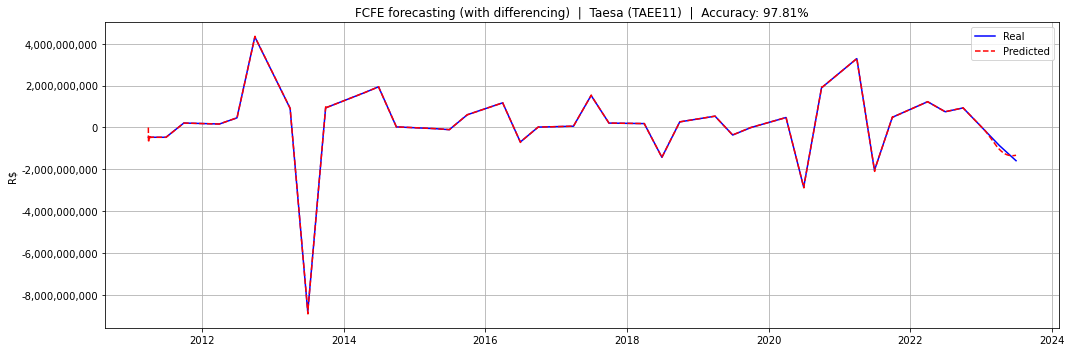

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def print_graph(company, company_data_real, company_data_pred, fcfe_accuracy):
    plt.figure(figsize=(15, 5))
    plt.plot(company_data_real.index, company_data_real, label='Real', color='blue')
    plt.plot(company_data_pred.index, company_data_pred, linestyle='--', label='Predicted', color='red')
    plt.title(f"FCFE forecasting (with differencing)  |  {company['name']} ({company['ticker']})  |  Accuracy: {fcfe_accuracy:.2f}%")
    plt.ylabel('R$')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load data
    df = read_csv('fcfe_pred', index_col='DT_REFER')

    for company_code in companies:
        print('\n-----------------------------------------------------------------\n')
        print(f'company_code: {company_code}')

        company = companies[company_code]
        company_data_real = df[df['CD_CVM'] == company_code]['FCFE']
        company_data_pred = df[df['CD_CVM'] == company_code]['FCFE_pred_arimax']

        fcfe_accuracy = accuracy(company_data_real, company_data_pred)
        print(f'FCFE accuracy: {fcfe_accuracy:.2f}%')

        # Visualize
        print_graph(company, company_data_real, company_data_pred, fcfe_accuracy)

saveToFile('fcfe', df, setIndex=False, verbose=False)

#### 5.3.4 Reverting diferentiation after forecasting


-----------------------------------------------------------------

company_code: 20257
FCFE accuracy: 94.13%


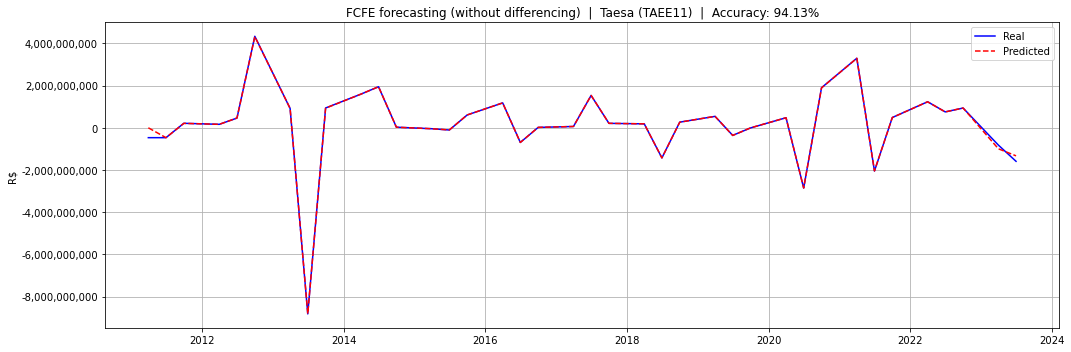

In [45]:
def load_df():
    df_interpolated = read_csv('fcfe', index_col='DT_REFER')

    # Check if 'FCFE' and 'FCFE_pred_arimax' exist in df_interpolated
    if 'FCFE' not in df_interpolated.columns or 'FCFE_pred_arimax' not in df_interpolated.columns:
        raise ValueError("Columns 'FCFE' or 'FCFE_pred_arimax' not found in df_interpolated!")

    interpolated_indices = [index for index in df_interpolated.index if index not in original_indices]
    df_original = df_interpolated.drop(interpolated_indices)
    assert len(original_indices) == len(df_original), "Mismatched sizes between interpolated_indices and df_original!"

    return df_original

def reverse_diff(column_name, df, diff_count):
    """Revert the differencing for a specific column."""
    for _ in range(diff_count):
        df[column_name] = df[column_name].cumsum()
    return df

def revert_differencing(reverse_diff, df_original):
    for account in columns_to_forecast:
        # Check if both the original column and its forecast are in the dataframe
        if account in df_original.columns:
            prediction_column = account + "_pred_arimax"
            if prediction_column in df_original.columns:
                diff_count = accounts_to_calculate_fcfe[account]['diff_count']
                
                # Revert the differencing for both the original and its prediction column
                df_original = reverse_diff(account, df_original, diff_count)
                df_original = reverse_diff(prediction_column, df_original, diff_count)
    return df_original

def remove_disposable_columns(df_original):
    columns_to_keep = ['CD_CVM']
    if 'FCFE' in df_original.columns:
        columns_to_keep.append('FCFE')
    if 'FCFE_pred_arimax' in df_original.columns:
        columns_to_keep.append('FCFE_pred_arimax')

    columns_to_keep.extend([col for col in columns_to_forecast if col in df_original.columns])

    for column in columns_to_forecast:
        prediction_column = f'{column}_pred_arimax'
        if prediction_column in df_original.columns:
            columns_to_keep.append(prediction_column)

    df_original = df_original[columns_to_keep]
    return df_original

def print_graph(company, company_data_real, company_data_pred, fcfe_accuracy):
    plt.figure(figsize=(15, 5))
    plt.plot(company_data_real.index, company_data_real, label='Real', color='blue')
    plt.plot(company_data_pred.index, company_data_pred, linestyle='--', label='Predicted', color='red')
    plt.title(f"FCFE forecasting (without differencing)  |  {company['name']} ({company['ticker']})  |  Accuracy: {fcfe_accuracy:.2f}%")
    plt.ylabel('R$')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    df_original = load_df()

    df_original = revert_differencing(reverse_diff, df_original)

    # To preserve the original index after reverting differencing
    df_original = df_original.loc[original_indices]

    df_original = remove_disposable_columns(df_original)

    for company_code in companies:
        print('\n-----------------------------------------------------------------\n')
        print(f'company_code: {company_code}')

        company = companies[company_code]
        company_data_real = df_original[df_original['CD_CVM'] == company_code]['FCFE']
        company_data_pred = df_original[df_original['CD_CVM'] == company_code]['FCFE_pred_arimax']

        fcfe_accuracy = accuracy(company_data_real, company_data_pred)
        print(f'FCFE accuracy: {fcfe_accuracy:.2f}%')

        # Visualize
        print_graph(company, company_data_real, company_data_pred, fcfe_accuracy)


saveToFile('fcfe_final', df_original, setIndex=False, verbose=False)
